
# Q learning (Q-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    #     print('state, action, reward, done, info')
    #     print(state, action, reward, done, info)
    if done:
    #         print('state, action, reward, done, info')
    #         print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Current actions given
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # TargetQs/values
    nextQs = tf.placeholder(tf.float32, [None], name='nextQs')
    
    # returning the given data to the model
    return states, actions, nextQs

In [7]:
# Q: Qfunction/Encoder/Classifier
def qfunction(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('qfunction', reuse=reuse):        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [8]:
def model_loss(states,  actions, nextQs, # model input data 
               action_size, hidden_size): # model init
    # DQN: Q-learning - Bellman equations: loss (targetQ - Q)^2
    actions_logits = qfunction(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_mask = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs_masked = tf.multiply(actions_logits, actions_mask)
    Qs = tf.reduce_max(Qs_masked, axis=1)
    
    # Calculating rewards/Rs as prob/sigmoid of Qs, i.e. between 0-1
    #Rs = tf.sigmoid(Qs) # qt
    qs = tf.sigmoid(Qs) # qt
    # Qs - (qs * targetQs)
    # Qs = qs + qs*nextQs
    targetQs = qs * (1 + nextQs)
    
    
    # Bellman equations is Qs = Rs + (0.99 * nextQs)
    #Qs = Rs + (gamma * nextQs)
    #Qs - Rs = gamma * nextQs
    # In this definition/description/explanation: targetQs = gamma * nextQs
    #Qs_Rs = Qs - Rs
    
    # Calculating the loss: logits/predictions vs labels
    q_loss = tf.reduce_mean(tf.square(Qs - targetQs))

    return actions_logits, q_loss, qs

In [9]:
def model_opt(q_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Qfunction/Value loss Tensor for next action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')] # Q: action At/at

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)

    return q_opt

In [11]:
class QGAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.nextQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.q_loss, self.Rs = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, nextQs=self.nextQs) # model input data

        # Update the model: backward pass and backprop
        self.q_opt = model_opt(q_loss=self.q_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [12]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [13]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [15]:
train_episodes = 10000         # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [16]:
tf.reset_default_graph()

model = QGAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [17]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [18]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
q_loss_list = []
meanRs_list, stdRs_list = [], []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    #     # Restore/load the trained model 
    #     #saver.restore(sess, 'checkpoints/model.ckpt')    
    #     saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        q_loss = 0
        meanRs, stdRs = 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training meanRs: {:.4f}'.format(np.mean(Rs)),
                      'Training stdRs: {:.4f}'.format(np.std(Rs)),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                q_loss_list.append((ep, q_loss))
                meanRs_list.append((ep, np.mean(Rs)))
                stdRs_list.append((ep, np.std(Rs)))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1) # boolean

            # Calculating targetQs = Rs + (gamma * nextQs)
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)            
            next_actions_mask = (1 - episode_ends.astype(next_actions_logits.dtype)).reshape(-1, 1) 
            #nextQs = next_actions_logits * next_actions_mask
            nextQs_masked = np.multiply(next_actions_logits, next_actions_mask)
            nextQs = np.max(nextQs_masked, axis=1)

            # Bellman equation: Qs = Rs + (gamma * nextQs)
            #targetQs = rewards + (gamma * nextQs)
            #targetQs = gamma * nextQs

            # Updating the model
            feed_dict = {model.states: states, model.actions: actions, model.nextQs: nextQs}
            Rs, q_loss, _ = sess.run([model.Rs, model.q_loss, model.q_opt], feed_dict)
            
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 48.0 Training meanRs: 0.9593 Training stdRs: 0.0251 Training q_loss: 2.4493 Explore P: 0.9953
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 12.0 Training meanRs: 0.9966 Training stdRs: 0.0029 Training q_loss: 5.9387 Explore P: 0.9941
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 12.0 Training meanRs: 1.0000 Training stdRs: 0.0001 Training q_loss: 14.0195 Explore P: 0.9929
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 29.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Train

-------------------------------------------------------------------------------
Episode: 30 Total reward: 44.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 226.2091 Explore P: 0.9328
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 31 Total reward: 12.0 Training meanRs: 0.9999 Training stdRs: 0.0007 Training q_loss: 293.0294 Explore P: 0.9317
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 32 Total reward: 49.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 384.0363 Explore P: 0.9272
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 33 Total reward: 22.0 Training meanRs: 1.0000 Training stdRs: 0.0

-------------------------------------------------------------------------------
Episode: 59 Total reward: 28.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 16567.6094 Explore P: 0.8689
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 60 Total reward: 40.0 Training meanRs: 0.9925 Training stdRs: 0.0608 Training q_loss: 28284.9453 Explore P: 0.8654
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 61 Total reward: 19.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 40492.0977 Explore P: 0.8638
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 62 Total reward: 41.0 Training meanRs: 0.9950 Training stdR

-------------------------------------------------------------------------------
Episode: 88 Total reward: 14.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 2622749.7500 Explore P: 0.7938
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 89 Total reward: 14.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 6708312.5000 Explore P: 0.7927
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 90 Total reward: 14.0 Training meanRs: 0.9975 Training stdRs: 0.0353 Training q_loss: 3259880.7500 Explore P: 0.7916
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 91 Total reward: 94.0 Training meanRs: 1.0000 Trainin

-------------------------------------------------------------------------------
Episode: 117 Total reward: 127.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 3373502208.0000 Explore P: 0.6895
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 118 Total reward: 156.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 2071204480.0000 Explore P: 0.6789
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 119 Total reward: 34.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 4860495360.0000 Explore P: 0.6767
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 120 Total reward: 40.0 Training meanRs:

-------------------------------------------------------------------------------
Episode: 146 Total reward: 199.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 68506853376.0000 Explore P: 0.5268
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 147 Total reward: 199.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 311995105280.0000 Explore P: 0.5166
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 148 Total reward: 199.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 243546750976.0000 Explore P: 0.5066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 149 Total reward: 70.0 Training m

-------------------------------------------------------------------------------
Episode: 174 Total reward: 199.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 8802802860032.0000 Explore P: 0.3321
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 175 Total reward: 199.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 4495641673728.0000 Explore P: 0.3257
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 176 Total reward: 199.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 667584299008.0000 Explore P: 0.3195
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 177 Total reward: 199.0 Traini

-------------------------------------------------------------------------------
Episode: 202 Total reward: 199.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 7843318071296.0000 Explore P: 0.1973
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 203 Total reward: 199.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 4596942503936.0000 Explore P: 0.1936
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 204 Total reward: 199.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 32972562497536.0000 Explore P: 0.1900
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 205 Total reward: 199.0 Trai

-------------------------------------------------------------------------------
Episode: 230 Total reward: 199.0 Training meanRs: 0.9975 Training stdRs: 0.0353 Training q_loss: 4663253925888.0000 Explore P: 0.1173
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 231 Total reward: 199.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 56313786662912.0000 Explore P: 0.1152
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 232 Total reward: 199.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 4082983501824.0000 Explore P: 0.1131
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 233 Total reward: 199.0 Trai

-------------------------------------------------------------------------------
Episode: 258 Total reward: 199.0 Training meanRs: 0.9900 Training stdRs: 0.0700 Training q_loss: 123700309393408.0000 Explore P: 0.0714
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 259 Total reward: 199.0 Training meanRs: 0.9875 Training stdRs: 0.0781 Training q_loss: 19356721348608.0000 Explore P: 0.0702
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 260 Total reward: 199.0 Training meanRs: 0.9900 Training stdRs: 0.0700 Training q_loss: 134991358984192.0000 Explore P: 0.0691
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 261 Total reward: 199.0 

-------------------------------------------------------------------------------
Episode: 286 Total reward: 199.0 Training meanRs: 0.9775 Training stdRs: 0.1037 Training q_loss: 121471800180736.0000 Explore P: 0.0452
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 287 Total reward: 199.0 Training meanRs: 0.9875 Training stdRs: 0.0781 Training q_loss: 252517367676928.0000 Explore P: 0.0445
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 288 Total reward: 199.0 Training meanRs: 0.9800 Training stdRs: 0.0980 Training q_loss: 79476062945280.0000 Explore P: 0.0438
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 289 Total reward: 199.0 

-------------------------------------------------------------------------------
Episode: 314 Total reward: 199.0 Training meanRs: 0.9625 Training stdRs: 0.1317 Training q_loss: 122012362080256.0000 Explore P: 0.0302
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 315 Total reward: 199.0 Training meanRs: 0.9625 Training stdRs: 0.1317 Training q_loss: 322491343962112.0000 Explore P: 0.0298
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 316 Total reward: 199.0 Training meanRs: 0.9725 Training stdRs: 0.1140 Training q_loss: 67801393922048.0000 Explore P: 0.0294
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 317 Total reward: 199.0 

-------------------------------------------------------------------------------
Episode: 342 Total reward: 199.0 Training meanRs: 0.9625 Training stdRs: 0.1317 Training q_loss: 98295779164160.0000 Explore P: 0.0215
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 343 Total reward: 199.0 Training meanRs: 0.9550 Training stdRs: 0.1431 Training q_loss: 118503164084224.0000 Explore P: 0.0213
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 344 Total reward: 199.0 Training meanRs: 0.9550 Training stdRs: 0.1431 Training q_loss: 67276019597312.0000 Explore P: 0.0211
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 345 Total reward: 199.0 T

-------------------------------------------------------------------------------
Episode: 370 Total reward: 199.0 Training meanRs: 0.9525 Training stdRs: 0.1466 Training q_loss: 329668838293504.0000 Explore P: 0.0166
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 371 Total reward: 199.0 Training meanRs: 0.9400 Training stdRs: 0.1625 Training q_loss: 276689208737792.0000 Explore P: 0.0165
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 372 Total reward: 199.0 Training meanRs: 0.9550 Training stdRs: 0.1431 Training q_loss: 268474781794304.0000 Explore P: 0.0164
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 373 Total reward: 199.0

-------------------------------------------------------------------------------
Episode: 398 Total reward: 199.0 Training meanRs: 0.9200 Training stdRs: 0.1833 Training q_loss: 378752362086400.0000 Explore P: 0.0138
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 399 Total reward: 199.0 Training meanRs: 0.9300 Training stdRs: 0.1735 Training q_loss: 181777763139584.0000 Explore P: 0.0137
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 400 Total reward: 199.0 Training meanRs: 0.9500 Training stdRs: 0.1500 Training q_loss: 100914853576704.0000 Explore P: 0.0136
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 401 Total reward: 199.0

-------------------------------------------------------------------------------
Episode: 426 Total reward: 199.0 Training meanRs: 0.9375 Training stdRs: 0.1654 Training q_loss: 408552019591168.0000 Explore P: 0.0122
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 427 Total reward: 199.0 Training meanRs: 0.9000 Training stdRs: 0.2000 Training q_loss: 570811958165504.0000 Explore P: 0.0121
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 428 Total reward: 199.0 Training meanRs: 0.9400 Training stdRs: 0.1625 Training q_loss: 654078824677376.0000 Explore P: 0.0121
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 429 Total reward: 199.0

-------------------------------------------------------------------------------
Episode: 454 Total reward: 199.0 Training meanRs: 0.9225 Training stdRs: 0.1810 Training q_loss: 717481735880704.0000 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 455 Total reward: 199.0 Training meanRs: 0.9425 Training stdRs: 0.1595 Training q_loss: 382545724178432.0000 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 456 Total reward: 199.0 Training meanRs: 0.9350 Training stdRs: 0.1682 Training q_loss: 1166182539329536.0000 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 457 Total reward: 199.

-------------------------------------------------------------------------------
Episode: 482 Total reward: 199.0 Training meanRs: 0.9150 Training stdRs: 0.1878 Training q_loss: 294849202880512.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 483 Total reward: 199.0 Training meanRs: 0.9025 Training stdRs: 0.1981 Training q_loss: 405044105052160.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 484 Total reward: 199.0 Training meanRs: 0.9350 Training stdRs: 0.1682 Training q_loss: 252141172162560.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 485 Total reward: 199.0

-------------------------------------------------------------------------------
Episode: 510 Total reward: 199.0 Training meanRs: 0.8500 Training stdRs: 0.2291 Training q_loss: 469417376874496.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 511 Total reward: 199.0 Training meanRs: 0.8600 Training stdRs: 0.2245 Training q_loss: 477668512366592.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 512 Total reward: 199.0 Training meanRs: 0.8675 Training stdRs: 0.2207 Training q_loss: 346117053087744.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 513 Total reward: 199.0

-------------------------------------------------------------------------------
Episode: 538 Total reward: 199.0 Training meanRs: 0.7975 Training stdRs: 0.2454 Training q_loss: 417295197274112.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 539 Total reward: 199.0 Training meanRs: 0.8200 Training stdRs: 0.2400 Training q_loss: 584654302216192.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 540 Total reward: 199.0 Training meanRs: 0.8425 Training stdRs: 0.2323 Training q_loss: 357565120643072.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 541 Total reward: 199.0

-------------------------------------------------------------------------------
Episode: 566 Total reward: 199.0 Training meanRs: 0.7800 Training stdRs: 0.2482 Training q_loss: 169860168417280.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 567 Total reward: 199.0 Training meanRs: 0.8325 Training stdRs: 0.2360 Training q_loss: 237785797623808.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 568 Total reward: 199.0 Training meanRs: 0.8300 Training stdRs: 0.2369 Training q_loss: 150656312672256.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 569 Total reward: 199.0

-------------------------------------------------------------------------------
Episode: 594 Total reward: 199.0 Training meanRs: 0.8400 Training stdRs: 0.2332 Training q_loss: 158092209684480.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 595 Total reward: 199.0 Training meanRs: 0.8525 Training stdRs: 0.2280 Training q_loss: 191913164537856.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 596 Total reward: 199.0 Training meanRs: 0.8625 Training stdRs: 0.2233 Training q_loss: 351083645894656.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 597 Total reward: 199.0

-------------------------------------------------------------------------------
Episode: 622 Total reward: 199.0 Training meanRs: 0.8775 Training stdRs: 0.2150 Training q_loss: 277697888518144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 623 Total reward: 199.0 Training meanRs: 0.8850 Training stdRs: 0.2104 Training q_loss: 371356562620416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 624 Total reward: 199.0 Training meanRs: 0.8675 Training stdRs: 0.2207 Training q_loss: 265176062361600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 625 Total reward: 199.0

-------------------------------------------------------------------------------
Episode: 650 Total reward: 199.0 Training meanRs: 0.9375 Training stdRs: 0.1654 Training q_loss: 24006191218688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 651 Total reward: 199.0 Training meanRs: 0.9150 Training stdRs: 0.1878 Training q_loss: 93390892957696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 652 Total reward: 199.0 Training meanRs: 0.9300 Training stdRs: 0.1735 Training q_loss: 53752736251904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 653 Total reward: 199.0 Tr

-------------------------------------------------------------------------------
Episode: 680 Total reward: 12.0 Training meanRs: 0.9625 Training stdRs: 0.1317 Training q_loss: 2441997071679488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 681 Total reward: 11.0 Training meanRs: 0.9550 Training stdRs: 0.1431 Training q_loss: 157507087499264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 682 Total reward: 9.0 Training meanRs: 0.9700 Training stdRs: 0.1187 Training q_loss: 754893786710016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 683 Total reward: 9.0 Trai

-------------------------------------------------------------------------------
Episode: 708 Total reward: 11.0 Training meanRs: 0.9625 Training stdRs: 0.1317 Training q_loss: 712211475464192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 709 Total reward: 10.0 Training meanRs: 0.9550 Training stdRs: 0.1431 Training q_loss: 1672316249440256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 710 Total reward: 10.0 Training meanRs: 0.9675 Training stdRs: 0.1233 Training q_loss: 955102210818048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 711 Total reward: 12.0 Tr

-------------------------------------------------------------------------------
Episode: 737 Total reward: 13.0 Training meanRs: 0.9750 Training stdRs: 0.1090 Training q_loss: 1046502470320128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 738 Total reward: 11.0 Training meanRs: 0.9825 Training stdRs: 0.0919 Training q_loss: 1480632127455232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 739 Total reward: 8.0 Training meanRs: 0.9650 Training stdRs: 0.1276 Training q_loss: 653935010381824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 740 Total reward: 9.0 Tra

-------------------------------------------------------------------------------
Episode: 766 Total reward: 10.0 Training meanRs: 0.9875 Training stdRs: 0.0781 Training q_loss: 1613163543920640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 767 Total reward: 11.0 Training meanRs: 0.9775 Training stdRs: 0.1037 Training q_loss: 5265038810021888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 768 Total reward: 9.0 Training meanRs: 0.9875 Training stdRs: 0.0781 Training q_loss: 55613841211392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 769 Total reward: 13.0 Tra

-------------------------------------------------------------------------------
Episode: 796 Total reward: 8.0 Training meanRs: 0.9500 Training stdRs: 0.1500 Training q_loss: 461359145811968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 797 Total reward: 10.0 Training meanRs: 0.9625 Training stdRs: 0.1317 Training q_loss: 61407588515840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 798 Total reward: 8.0 Training meanRs: 0.9675 Training stdRs: 0.1233 Training q_loss: 5718575008448512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 799 Total reward: 10.0 Train

-------------------------------------------------------------------------------
Episode: 824 Total reward: 8.0 Training meanRs: 0.9700 Training stdRs: 0.1187 Training q_loss: 59424798408704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 825 Total reward: 10.0 Training meanRs: 0.9850 Training stdRs: 0.0853 Training q_loss: 1509521285447680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 826 Total reward: 11.0 Training meanRs: 0.9725 Training stdRs: 0.1140 Training q_loss: 117989512839168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 827 Total reward: 11.0 Trai

-------------------------------------------------------------------------------
Episode: 854 Total reward: 8.0 Training meanRs: 0.9675 Training stdRs: 0.1233 Training q_loss: 847053383008256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 855 Total reward: 10.0 Training meanRs: 0.9600 Training stdRs: 0.1356 Training q_loss: 161152659095552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 856 Total reward: 7.0 Training meanRs: 0.9625 Training stdRs: 0.1317 Training q_loss: 1752458191699968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 857 Total reward: 11.0 Trai

-------------------------------------------------------------------------------
Episode: 883 Total reward: 11.0 Training meanRs: 0.9650 Training stdRs: 0.1276 Training q_loss: 4707147791204352.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 884 Total reward: 12.0 Training meanRs: 0.9850 Training stdRs: 0.0853 Training q_loss: 5558127378300928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 885 Total reward: 8.0 Training meanRs: 0.9650 Training stdRs: 0.1276 Training q_loss: 5049785249693696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 886 Total reward: 10.0 T

-------------------------------------------------------------------------------
Episode: 912 Total reward: 8.0 Training meanRs: 0.9600 Training stdRs: 0.1356 Training q_loss: 85724158230528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 913 Total reward: 11.0 Training meanRs: 0.9725 Training stdRs: 0.1140 Training q_loss: 724249195053056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 914 Total reward: 11.0 Training meanRs: 0.9650 Training stdRs: 0.1276 Training q_loss: 7929146894188544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 915 Total reward: 10.0 Trai

-------------------------------------------------------------------------------
Episode: 941 Total reward: 15.0 Training meanRs: 0.9675 Training stdRs: 0.1233 Training q_loss: 1332499242287104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 942 Total reward: 12.0 Training meanRs: 0.9750 Training stdRs: 0.1090 Training q_loss: 77204033634304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 943 Total reward: 13.0 Training meanRs: 0.9650 Training stdRs: 0.1276 Training q_loss: 1114761848684544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 944 Total reward: 14.0 Tr

-------------------------------------------------------------------------------
Episode: 969 Total reward: 199.0 Training meanRs: 0.9400 Training stdRs: 0.1625 Training q_loss: 604242372984832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 970 Total reward: 199.0 Training meanRs: 0.9500 Training stdRs: 0.1500 Training q_loss: 833378341355520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 971 Total reward: 199.0 Training meanRs: 0.9225 Training stdRs: 0.1810 Training q_loss: 1107871781617664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 972 Total reward: 199.

-------------------------------------------------------------------------------
Episode: 999 Total reward: 11.0 Training meanRs: 0.9900 Training stdRs: 0.0700 Training q_loss: 7154399218499584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1000 Total reward: 10.0 Training meanRs: 0.9725 Training stdRs: 0.1140 Training q_loss: 621904687792128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1001 Total reward: 9.0 Training meanRs: 0.9775 Training stdRs: 0.1037 Training q_loss: 11848984767234048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1002 Total reward: 12.

-------------------------------------------------------------------------------
Episode: 1028 Total reward: 10.0 Training meanRs: 0.9750 Training stdRs: 0.1090 Training q_loss: 8127344602513408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1029 Total reward: 12.0 Training meanRs: 0.9750 Training stdRs: 0.1090 Training q_loss: 19836982913925120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1030 Total reward: 11.0 Training meanRs: 0.9550 Training stdRs: 0.1431 Training q_loss: 7395069321543680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1031 Total reward: 

-------------------------------------------------------------------------------
Episode: 1058 Total reward: 13.0 Training meanRs: 0.9725 Training stdRs: 0.1140 Training q_loss: 18633833725296640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1059 Total reward: 12.0 Training meanRs: 0.9800 Training stdRs: 0.0980 Training q_loss: 28146112544112640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1060 Total reward: 9.0 Training meanRs: 0.9725 Training stdRs: 0.1140 Training q_loss: 1024497540923392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1061 Total reward: 

-------------------------------------------------------------------------------
Episode: 1087 Total reward: 13.0 Training meanRs: 0.9925 Training stdRs: 0.0608 Training q_loss: 994211914579968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1088 Total reward: 9.0 Training meanRs: 0.9850 Training stdRs: 0.0853 Training q_loss: 5965408389562368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1089 Total reward: 9.0 Training meanRs: 0.9850 Training stdRs: 0.0853 Training q_loss: 1007065208193024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1090 Total reward: 10.0

-------------------------------------------------------------------------------
Episode: 1116 Total reward: 10.0 Training meanRs: 0.9925 Training stdRs: 0.0608 Training q_loss: 7244014248001536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1117 Total reward: 14.0 Training meanRs: 0.9850 Training stdRs: 0.0853 Training q_loss: 9111911631159296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1118 Total reward: 10.0 Training meanRs: 0.9775 Training stdRs: 0.1037 Training q_loss: 7128087175102464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1119 Total reward: 1

-------------------------------------------------------------------------------
Episode: 1144 Total reward: 15.0 Training meanRs: 0.9925 Training stdRs: 0.0608 Training q_loss: 5703827701366784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1145 Total reward: 13.0 Training meanRs: 0.9875 Training stdRs: 0.0781 Training q_loss: 5702447943122944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1146 Total reward: 14.0 Training meanRs: 0.9850 Training stdRs: 0.0853 Training q_loss: 7615973448220672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1147 Total reward: 1

-------------------------------------------------------------------------------
Episode: 1172 Total reward: 199.0 Training meanRs: 0.9825 Training stdRs: 0.0919 Training q_loss: 4075868666200064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1173 Total reward: 199.0 Training meanRs: 0.9700 Training stdRs: 0.1187 Training q_loss: 92447573318565888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1174 Total reward: 199.0 Training meanRs: 0.9875 Training stdRs: 0.0781 Training q_loss: 8873075479150592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1175 Total rewar

-------------------------------------------------------------------------------
Episode: 1200 Total reward: 199.0 Training meanRs: 0.9500 Training stdRs: 0.1500 Training q_loss: 1369043776831488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1201 Total reward: 199.0 Training meanRs: 0.9250 Training stdRs: 0.1785 Training q_loss: 912255549964288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1202 Total reward: 199.0 Training meanRs: 0.9475 Training stdRs: 0.1533 Training q_loss: 1207713665122304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1203 Total reward:

-------------------------------------------------------------------------------
Episode: 1228 Total reward: 199.0 Training meanRs: 0.9275 Training stdRs: 0.1761 Training q_loss: 4186192685826048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1229 Total reward: 199.0 Training meanRs: 0.9100 Training stdRs: 0.1921 Training q_loss: 5114289752899584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1230 Total reward: 199.0 Training meanRs: 0.9075 Training stdRs: 0.1941 Training q_loss: 8127050934124544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1231 Total reward

-------------------------------------------------------------------------------
Episode: 1256 Total reward: 199.0 Training meanRs: 0.9125 Training stdRs: 0.1900 Training q_loss: 3063733047787520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1257 Total reward: 199.0 Training meanRs: 0.8800 Training stdRs: 0.2135 Training q_loss: 4282730128867328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1258 Total reward: 199.0 Training meanRs: 0.9225 Training stdRs: 0.1810 Training q_loss: 2875266393178112.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1259 Total reward

-------------------------------------------------------------------------------
Episode: 1284 Total reward: 199.0 Training meanRs: 0.9350 Training stdRs: 0.1682 Training q_loss: 6163238341312512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1285 Total reward: 199.0 Training meanRs: 0.9325 Training stdRs: 0.1709 Training q_loss: 2466469258461184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1286 Total reward: 199.0 Training meanRs: 0.9200 Training stdRs: 0.1833 Training q_loss: 32472484640980992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1287 Total rewar

-------------------------------------------------------------------------------
Episode: 1312 Total reward: 199.0 Training meanRs: 0.9425 Training stdRs: 0.1595 Training q_loss: 1934820087169024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1313 Total reward: 199.0 Training meanRs: 0.9575 Training stdRs: 0.1394 Training q_loss: 5054016329351168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1314 Total reward: 199.0 Training meanRs: 0.9425 Training stdRs: 0.1595 Training q_loss: 1527230240915456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1315 Total reward

-------------------------------------------------------------------------------
Episode: 1340 Total reward: 199.0 Training meanRs: 0.9525 Training stdRs: 0.1466 Training q_loss: 11771496041021440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1341 Total reward: 199.0 Training meanRs: 0.9650 Training stdRs: 0.1276 Training q_loss: 7150984719499264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1342 Total reward: 199.0 Training meanRs: 0.9650 Training stdRs: 0.1276 Training q_loss: 1130856164884480.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1343 Total rewar

-------------------------------------------------------------------------------
Episode: 1368 Total reward: 199.0 Training meanRs: 0.9750 Training stdRs: 0.1090 Training q_loss: 1897658822164480.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1369 Total reward: 199.0 Training meanRs: 0.9750 Training stdRs: 0.1090 Training q_loss: 1045206061285376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1370 Total reward: 199.0 Training meanRs: 0.9775 Training stdRs: 0.1037 Training q_loss: 1868421637603328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1371 Total reward

-------------------------------------------------------------------------------
Episode: 1396 Total reward: 199.0 Training meanRs: 0.9775 Training stdRs: 0.1037 Training q_loss: 11449755745910784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1397 Total reward: 199.0 Training meanRs: 0.9900 Training stdRs: 0.0700 Training q_loss: 4282809048891392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1398 Total reward: 199.0 Training meanRs: 0.9775 Training stdRs: 0.1037 Training q_loss: 2213918739005440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1399 Total rewar

-------------------------------------------------------------------------------
Episode: 1424 Total reward: 199.0 Training meanRs: 0.9800 Training stdRs: 0.0980 Training q_loss: 5500896402210816.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1425 Total reward: 185.0 Training meanRs: 0.9825 Training stdRs: 0.0919 Training q_loss: 14943279996993536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1426 Total reward: 199.0 Training meanRs: 0.9900 Training stdRs: 0.0700 Training q_loss: 1549781100920832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1427 Total rewar

-------------------------------------------------------------------------------
Episode: 1452 Total reward: 168.0 Training meanRs: 0.9600 Training stdRs: 0.1356 Training q_loss: 25206866707480576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1453 Total reward: 196.0 Training meanRs: 0.9625 Training stdRs: 0.1317 Training q_loss: 17607191586406400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1454 Total reward: 199.0 Training meanRs: 0.9525 Training stdRs: 0.1466 Training q_loss: 41812893900996608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1455 Total rew

-------------------------------------------------------------------------------
Episode: 1480 Total reward: 155.0 Training meanRs: 0.9125 Training stdRs: 0.1900 Training q_loss: 94584388267802624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1481 Total reward: 187.0 Training meanRs: 0.8975 Training stdRs: 0.2019 Training q_loss: 149657980810297344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1482 Total reward: 199.0 Training meanRs: 0.9050 Training stdRs: 0.1962 Training q_loss: 165385085896359936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1483 Total r

-------------------------------------------------------------------------------
Episode: 1508 Total reward: 199.0 Training meanRs: 0.8125 Training stdRs: 0.2421 Training q_loss: 477653964507054080.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1509 Total reward: 199.0 Training meanRs: 0.7950 Training stdRs: 0.2459 Training q_loss: 527237643952455680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1510 Total reward: 199.0 Training meanRs: 0.8050 Training stdRs: 0.2439 Training q_loss: 693014207527911424.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1511 Total 

-------------------------------------------------------------------------------
Episode: 1536 Total reward: 199.0 Training meanRs: 0.7625 Training stdRs: 0.2497 Training q_loss: 550625183988187136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1537 Total reward: 199.0 Training meanRs: 0.7725 Training stdRs: 0.2490 Training q_loss: 860131659893178368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1538 Total reward: 199.0 Training meanRs: 0.7625 Training stdRs: 0.2497 Training q_loss: 761498869811904512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1539 Total 

-------------------------------------------------------------------------------
Episode: 1564 Total reward: 199.0 Training meanRs: 0.8150 Training stdRs: 0.2414 Training q_loss: 488188144894607360.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1565 Total reward: 199.0 Training meanRs: 0.7950 Training stdRs: 0.2459 Training q_loss: 495399910380666880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1566 Total reward: 199.0 Training meanRs: 0.7950 Training stdRs: 0.2459 Training q_loss: 628470126198390784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1567 Total 

-------------------------------------------------------------------------------
Episode: 1592 Total reward: 199.0 Training meanRs: 0.8600 Training stdRs: 0.2245 Training q_loss: 489887818072457216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1593 Total reward: 199.0 Training meanRs: 0.8800 Training stdRs: 0.2135 Training q_loss: 277273193025110016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1594 Total reward: 199.0 Training meanRs: 0.8775 Training stdRs: 0.2150 Training q_loss: 323151243406999552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1595 Total 

-------------------------------------------------------------------------------
Episode: 1620 Total reward: 199.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 7130809110626304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1621 Total reward: 199.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 31743922896109568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1622 Total reward: 138.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 16061336219811840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1623 Total rewa

-------------------------------------------------------------------------------
Episode: 1648 Total reward: 13.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 139713095705559040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1649 Total reward: 12.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 12140139526488064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1650 Total reward: 13.0 Training meanRs: 0.9975 Training stdRs: 0.0353 Training q_loss: 97796637258153984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1651 Total rewar

-------------------------------------------------------------------------------
Episode: 1676 Total reward: 11.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 116125229805207552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1677 Total reward: 9.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 139944474183729152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1678 Total reward: 9.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 172042852140843008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1679 Total rewar

-------------------------------------------------------------------------------
Episode: 1706 Total reward: 9.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 13958600762327040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1707 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 227825028387831808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1708 Total reward: 8.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 281031272229240832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1709 Total reward

-------------------------------------------------------------------------------
Episode: 1734 Total reward: 11.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 147517832966438912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1735 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 26387299814080512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1736 Total reward: 8.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 82576862299029504.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1737 Total reward

-------------------------------------------------------------------------------
Episode: 1763 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 553833936875159552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1764 Total reward: 11.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 824483568775331840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1765 Total reward: 9.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 957045500983377920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1766 Total rewa

-------------------------------------------------------------------------------
Episode: 1791 Total reward: 15.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 16286338819031040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1792 Total reward: 11.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1373774907720073216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1793 Total reward: 7.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 99374247465451520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1794 Total rewar

-------------------------------------------------------------------------------
Episode: 1819 Total reward: 17.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1102360256245137408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1820 Total reward: 20.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 162837654893756416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1821 Total reward: 21.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 9086952502460416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1822 Total rewa

-------------------------------------------------------------------------------
Episode: 1847 Total reward: 26.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 232369859701243904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1848 Total reward: 24.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 632371674490077184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1849 Total reward: 25.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 228368015333261312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1850 Total rew

-------------------------------------------------------------------------------
Episode: 1876 Total reward: 13.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 13386161078665216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1877 Total reward: 18.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 225805053728915456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1878 Total reward: 15.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 12697106590466048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1879 Total rewar

-------------------------------------------------------------------------------
Episode: 1905 Total reward: 11.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 673939398772916224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1906 Total reward: 13.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 20080599901405184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1907 Total reward: 13.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 85483318207840256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1908 Total rewar

-------------------------------------------------------------------------------
Episode: 1934 Total reward: 13.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1002858851977920512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1935 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 20960056732286976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1936 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 19756856004050944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1937 Total rewa

-------------------------------------------------------------------------------
Episode: 1964 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 23138242954002432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1965 Total reward: 12.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 950753683132383232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1966 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 744715237130764288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1967 Total rewa

-------------------------------------------------------------------------------
Episode: 1995 Total reward: 8.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1157511141019090944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1996 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 448411593772892160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1997 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 260898183532511232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1998 Total rew

-------------------------------------------------------------------------------
Episode: 2025 Total reward: 9.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1996570042090651648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2026 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 870619488993673216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2027 Total reward: 12.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 34764738751627264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2028 Total rewa

-------------------------------------------------------------------------------
Episode: 2055 Total reward: 8.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 447682686283153408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2056 Total reward: 12.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1882535842883305472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2057 Total reward: 7.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1811546149513854976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2058 Total rew

-------------------------------------------------------------------------------
Episode: 2083 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 152225031223508992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2084 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 724152514265481216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2085 Total reward: 11.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 937532949161574400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2086 Total rew

-------------------------------------------------------------------------------
Episode: 2112 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 932426267406368768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2113 Total reward: 12.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 2352913926632505344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2114 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 469663744788529152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2115 Total re

-------------------------------------------------------------------------------
Episode: 2140 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 651820454637469696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2141 Total reward: 13.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 940817877588508672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2142 Total reward: 13.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 37688269302923264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2143 Total rewa

-------------------------------------------------------------------------------
Episode: 2169 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 594173197432127488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2170 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1274851709130113024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2171 Total reward: 11.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1036092209402740736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2172 Total r

-------------------------------------------------------------------------------
Episode: 2197 Total reward: 9.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 34159472632922112.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2198 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 207457004980011008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2199 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1757278241296482304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2200 Total rewa

-------------------------------------------------------------------------------
Episode: 2227 Total reward: 12.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1474201551022063616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2228 Total reward: 13.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1726906019285565440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2229 Total reward: 15.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1029643092669497344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2230 Total 

-------------------------------------------------------------------------------
Episode: 2256 Total reward: 14.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1806470528962134016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2257 Total reward: 15.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 899885258709663744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2258 Total reward: 13.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 2801312360625602560.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2259 Total r

-------------------------------------------------------------------------------
Episode: 2284 Total reward: 21.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 903516189701963776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2285 Total reward: 17.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 818564141768769536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2286 Total reward: 21.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1037249101793591296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2287 Total re

-------------------------------------------------------------------------------
Episode: 2312 Total reward: 24.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1337480578643001344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2313 Total reward: 25.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1366759336340094976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2314 Total reward: 25.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 327902817266171904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2315 Total r

-------------------------------------------------------------------------------
Episode: 2340 Total reward: 64.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 866766319213608960.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2341 Total reward: 66.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1769829853722312704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2342 Total reward: 60.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 248855438831910912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2343 Total re

-------------------------------------------------------------------------------
Episode: 2368 Total reward: 88.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 257277165324730368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2369 Total reward: 102.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 233086500764385280.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2370 Total reward: 83.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 31716533889662976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2371 Total rew

-------------------------------------------------------------------------------
Episode: 2396 Total reward: 127.0 Training meanRs: 0.9700 Training stdRs: 0.1187 Training q_loss: 30401517982842880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2397 Total reward: 171.0 Training meanRs: 0.9650 Training stdRs: 0.1276 Training q_loss: 38465546714349568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2398 Total reward: 199.0 Training meanRs: 0.9800 Training stdRs: 0.0980 Training q_loss: 41677417747578880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2399 Total rew

-------------------------------------------------------------------------------
Episode: 2424 Total reward: 150.0 Training meanRs: 0.9500 Training stdRs: 0.1500 Training q_loss: 73756305143103488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2425 Total reward: 110.0 Training meanRs: 0.9225 Training stdRs: 0.1810 Training q_loss: 318592187161903104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2426 Total reward: 143.0 Training meanRs: 0.9275 Training stdRs: 0.1761 Training q_loss: 251270705100881920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2427 Total r

-------------------------------------------------------------------------------
Episode: 2452 Total reward: 199.0 Training meanRs: 0.8475 Training stdRs: 0.2302 Training q_loss: 664421201489166336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2453 Total reward: 192.0 Training meanRs: 0.8650 Training stdRs: 0.2220 Training q_loss: 817312004183162880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2454 Total reward: 199.0 Training meanRs: 0.8500 Training stdRs: 0.2291 Training q_loss: 1438078745758924800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2455 Total

-------------------------------------------------------------------------------
Episode: 2480 Total reward: 199.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 95777659031650304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2481 Total reward: 150.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 93217300177485824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2482 Total reward: 129.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 694388116026294272.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2483 Total re

-------------------------------------------------------------------------------
Episode: 2508 Total reward: 14.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 271807984579903488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2509 Total reward: 13.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 76918388915437568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2510 Total reward: 12.0 Training meanRs: 0.9975 Training stdRs: 0.0353 Training q_loss: 1906591920348463104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2511 Total rew

-------------------------------------------------------------------------------
Episode: 2536 Total reward: 9.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 2409495894509486080.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2537 Total reward: 9.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 475367083400495104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2538 Total reward: 12.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 3039547943062339584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2539 Total rew

-------------------------------------------------------------------------------
Episode: 2564 Total reward: 9.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 534139312799744000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2565 Total reward: 8.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1914310766853357568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2566 Total reward: 8.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1607425114352123904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2567 Total rewa

-------------------------------------------------------------------------------
Episode: 2593 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1867351724742672384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2594 Total reward: 9.0 Training meanRs: 0.9975 Training stdRs: 0.0353 Training q_loss: 2705379146468425728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2595 Total reward: 12.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 2589139052057853952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2596 Total r

-------------------------------------------------------------------------------
Episode: 2623 Total reward: 12.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 3631863103282479104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2624 Total reward: 11.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 101537966089830400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2625 Total reward: 12.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 3363375008163299328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2626 Total r

-------------------------------------------------------------------------------
Episode: 2651 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 2763903126757965824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2652 Total reward: 7.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 2197259226584186880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2653 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 95875214918811648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2654 Total rew

-------------------------------------------------------------------------------
Episode: 2680 Total reward: 9.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 95086040447975424.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2681 Total reward: 8.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 3878246341758943232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2682 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 3973799399770816512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2683 Total rewa

-------------------------------------------------------------------------------
Episode: 2709 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 2172320241281925120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2710 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 965537372882075648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2711 Total reward: 9.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1980194877979230208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2712 Total re

-------------------------------------------------------------------------------
Episode: 2737 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 5036640665493045248.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2738 Total reward: 13.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1487881949572759552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2739 Total reward: 11.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1511762929811193856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2740 Total 

-------------------------------------------------------------------------------
Episode: 2765 Total reward: 15.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 5349496253816242176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2766 Total reward: 12.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 3060872421327241216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2767 Total reward: 15.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 401214954071392256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2768 Total r

-------------------------------------------------------------------------------
Episode: 2793 Total reward: 29.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 2812636780635881472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2794 Total reward: 30.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 381522803897139200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2795 Total reward: 29.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 643017764545495040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2796 Total re

-------------------------------------------------------------------------------
Episode: 2821 Total reward: 199.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 489795871412584448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2822 Total reward: 88.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 304686010770391040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2823 Total reward: 199.0 Training meanRs: 0.9925 Training stdRs: 0.0608 Training q_loss: 94691418852818944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2824 Total re

-------------------------------------------------------------------------------
Episode: 2849 Total reward: 199.0 Training meanRs: 0.8825 Training stdRs: 0.2120 Training q_loss: 663990673967415296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2850 Total reward: 124.0 Training meanRs: 0.8650 Training stdRs: 0.2220 Training q_loss: 682539091530612736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2851 Total reward: 168.0 Training meanRs: 0.8500 Training stdRs: 0.2291 Training q_loss: 949520580841832448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2852 Total 

-------------------------------------------------------------------------------
Episode: 2877 Total reward: 199.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 6405120698875904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2878 Total reward: 199.0 Training meanRs: 0.9950 Training stdRs: 0.0497 Training q_loss: 13643378080088064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2879 Total reward: 199.0 Training meanRs: 0.9950 Training stdRs: 0.0497 Training q_loss: 119325392757587968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2880 Total rew

-------------------------------------------------------------------------------
Episode: 2905 Total reward: 199.0 Training meanRs: 0.9975 Training stdRs: 0.0353 Training q_loss: 59358239032082432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2906 Total reward: 199.0 Training meanRs: 0.9925 Training stdRs: 0.0608 Training q_loss: 29356707058548736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2907 Total reward: 199.0 Training meanRs: 0.9675 Training stdRs: 0.1233 Training q_loss: 7427924747616256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2908 Total rewa

-------------------------------------------------------------------------------
Episode: 2933 Total reward: 199.0 Training meanRs: 0.9875 Training stdRs: 0.0781 Training q_loss: 21330379549966336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2934 Total reward: 199.0 Training meanRs: 0.9550 Training stdRs: 0.1431 Training q_loss: 72616291973726208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2935 Total reward: 199.0 Training meanRs: 0.9525 Training stdRs: 0.1466 Training q_loss: 28484332628738048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2936 Total rew

-------------------------------------------------------------------------------
Episode: 2961 Total reward: 199.0 Training meanRs: 0.9275 Training stdRs: 0.1761 Training q_loss: 165064973393854464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2962 Total reward: 199.0 Training meanRs: 0.9450 Training stdRs: 0.1564 Training q_loss: 98221495423074304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2963 Total reward: 199.0 Training meanRs: 0.9475 Training stdRs: 0.1533 Training q_loss: 143526313699835904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2964 Total r

-------------------------------------------------------------------------------
Episode: 2989 Total reward: 199.0 Training meanRs: 0.9525 Training stdRs: 0.1466 Training q_loss: 68330116475781120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2990 Total reward: 199.0 Training meanRs: 0.9475 Training stdRs: 0.1533 Training q_loss: 84497451414716416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2991 Total reward: 199.0 Training meanRs: 0.9500 Training stdRs: 0.1500 Training q_loss: 54194636075302912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2992 Total rew

-------------------------------------------------------------------------------
Episode: 3017 Total reward: 199.0 Training meanRs: 0.9900 Training stdRs: 0.0700 Training q_loss: 20094397483843584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3018 Total reward: 199.0 Training meanRs: 0.9925 Training stdRs: 0.0608 Training q_loss: 9319990985490432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3019 Total reward: 199.0 Training meanRs: 0.9950 Training stdRs: 0.0497 Training q_loss: 26041292953747456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3020 Total rewa

-------------------------------------------------------------------------------
Episode: 3045 Total reward: 199.0 Training meanRs: 0.9800 Training stdRs: 0.0980 Training q_loss: 15305311380307968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3046 Total reward: 199.0 Training meanRs: 0.9925 Training stdRs: 0.0608 Training q_loss: 2554433409908736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3047 Total reward: 199.0 Training meanRs: 0.9850 Training stdRs: 0.0853 Training q_loss: 5518457986613248.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3048 Total rewar

-------------------------------------------------------------------------------
Episode: 3073 Total reward: 199.0 Training meanRs: 0.9775 Training stdRs: 0.1037 Training q_loss: 27340761078956032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3074 Total reward: 199.0 Training meanRs: 0.9850 Training stdRs: 0.0853 Training q_loss: 2660930613673984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3075 Total reward: 199.0 Training meanRs: 0.9925 Training stdRs: 0.0608 Training q_loss: 29179447315791872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3076 Total rewa

-------------------------------------------------------------------------------
Episode: 3101 Total reward: 199.0 Training meanRs: 0.9850 Training stdRs: 0.0853 Training q_loss: 2454908011806720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3102 Total reward: 199.0 Training meanRs: 0.9925 Training stdRs: 0.0608 Training q_loss: 36527300988108800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3103 Total reward: 199.0 Training meanRs: 0.9900 Training stdRs: 0.0700 Training q_loss: 2798224880435200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3104 Total rewar

-------------------------------------------------------------------------------
Episode: 3129 Total reward: 199.0 Training meanRs: 0.9850 Training stdRs: 0.0853 Training q_loss: 4875732236894208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3130 Total reward: 199.0 Training meanRs: 0.9875 Training stdRs: 0.0781 Training q_loss: 5604779313070080.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3131 Total reward: 199.0 Training meanRs: 0.9850 Training stdRs: 0.0853 Training q_loss: 1484376130977792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3132 Total reward

-------------------------------------------------------------------------------
Episode: 3157 Total reward: 199.0 Training meanRs: 0.9875 Training stdRs: 0.0781 Training q_loss: 3544390890946560.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3158 Total reward: 199.0 Training meanRs: 0.9850 Training stdRs: 0.0853 Training q_loss: 7515814274007040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3159 Total reward: 199.0 Training meanRs: 0.9800 Training stdRs: 0.0980 Training q_loss: 6314860350537728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3160 Total reward

-------------------------------------------------------------------------------
Episode: 3185 Total reward: 199.0 Training meanRs: 0.9875 Training stdRs: 0.0781 Training q_loss: 5947773790715904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3186 Total reward: 199.0 Training meanRs: 0.9900 Training stdRs: 0.0700 Training q_loss: 5115247530606592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3187 Total reward: 199.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 918503250984960.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3188 Total reward:

-------------------------------------------------------------------------------
Episode: 3213 Total reward: 199.0 Training meanRs: 0.9825 Training stdRs: 0.0919 Training q_loss: 8362807057711104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3214 Total reward: 199.0 Training meanRs: 0.9850 Training stdRs: 0.0853 Training q_loss: 24621204966998016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3215 Total reward: 199.0 Training meanRs: 0.9725 Training stdRs: 0.1140 Training q_loss: 8893179684192256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3216 Total rewar

-------------------------------------------------------------------------------
Episode: 3241 Total reward: 199.0 Training meanRs: 0.8725 Training stdRs: 0.2179 Training q_loss: 38168068689494016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3242 Total reward: 199.0 Training meanRs: 0.8750 Training stdRs: 0.2165 Training q_loss: 41148058733379584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3243 Total reward: 199.0 Training meanRs: 0.8750 Training stdRs: 0.2165 Training q_loss: 37705015380410368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3244 Total rew

-------------------------------------------------------------------------------
Episode: 3269 Total reward: 199.0 Training meanRs: 0.7650 Training stdRs: 0.2495 Training q_loss: 45507759776464896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3270 Total reward: 199.0 Training meanRs: 0.7125 Training stdRs: 0.2472 Training q_loss: 63239669696954368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3271 Total reward: 199.0 Training meanRs: 0.7875 Training stdRs: 0.2472 Training q_loss: 17272723155714048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3272 Total rew

-------------------------------------------------------------------------------
Episode: 3297 Total reward: 199.0 Training meanRs: 0.7275 Training stdRs: 0.2490 Training q_loss: 127103819048812544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3298 Total reward: 146.0 Training meanRs: 0.7350 Training stdRs: 0.2495 Training q_loss: 66555594902863872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3299 Total reward: 199.0 Training meanRs: 0.7125 Training stdRs: 0.2472 Training q_loss: 39600959973752832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3300 Total re

-------------------------------------------------------------------------------
Episode: 3325 Total reward: 199.0 Training meanRs: 0.6800 Training stdRs: 0.2400 Training q_loss: 115127388643262464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3326 Total reward: 123.0 Training meanRs: 0.7150 Training stdRs: 0.2475 Training q_loss: 58140057457917952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3327 Total reward: 199.0 Training meanRs: 0.7000 Training stdRs: 0.2449 Training q_loss: 80870428842655744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3328 Total re

-------------------------------------------------------------------------------
Episode: 3353 Total reward: 199.0 Training meanRs: 0.6400 Training stdRs: 0.2245 Training q_loss: 139311018047176704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3354 Total reward: 199.0 Training meanRs: 0.6850 Training stdRs: 0.2414 Training q_loss: 47881429287174144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3355 Total reward: 199.0 Training meanRs: 0.6375 Training stdRs: 0.2233 Training q_loss: 52242315741233152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3356 Total re

-------------------------------------------------------------------------------
Episode: 3381 Total reward: 199.0 Training meanRs: 0.6475 Training stdRs: 0.2280 Training q_loss: 50189364323418112.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3382 Total reward: 199.0 Training meanRs: 0.6675 Training stdRs: 0.2360 Training q_loss: 52867778943647744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3383 Total reward: 199.0 Training meanRs: 0.6575 Training stdRs: 0.2323 Training q_loss: 58318981500502016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3384 Total rew

-------------------------------------------------------------------------------
Episode: 3409 Total reward: 199.0 Training meanRs: 0.6700 Training stdRs: 0.2369 Training q_loss: 73941083226112000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3410 Total reward: 199.0 Training meanRs: 0.6725 Training stdRs: 0.2377 Training q_loss: 95927063764008960.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3411 Total reward: 199.0 Training meanRs: 0.7100 Training stdRs: 0.2468 Training q_loss: 49314475190255616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3412 Total rew

-------------------------------------------------------------------------------
Episode: 3437 Total reward: 199.0 Training meanRs: 0.6950 Training stdRs: 0.2439 Training q_loss: 46585075013255168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3438 Total reward: 199.0 Training meanRs: 0.7275 Training stdRs: 0.2490 Training q_loss: 42267443174834176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3439 Total reward: 199.0 Training meanRs: 0.7700 Training stdRs: 0.2492 Training q_loss: 27417823529664512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3440 Total rew

-------------------------------------------------------------------------------
Episode: 3465 Total reward: 199.0 Training meanRs: 0.7600 Training stdRs: 0.2498 Training q_loss: 34908991670714368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3466 Total reward: 199.0 Training meanRs: 0.7875 Training stdRs: 0.2472 Training q_loss: 39947920316825600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3467 Total reward: 199.0 Training meanRs: 0.7800 Training stdRs: 0.2482 Training q_loss: 47897814587408384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3468 Total rew

-------------------------------------------------------------------------------
Episode: 3493 Total reward: 199.0 Training meanRs: 0.7900 Training stdRs: 0.2468 Training q_loss: 18618367548063744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3494 Total reward: 199.0 Training meanRs: 0.7900 Training stdRs: 0.2468 Training q_loss: 37525867999526912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3495 Total reward: 199.0 Training meanRs: 0.7900 Training stdRs: 0.2468 Training q_loss: 37887787713691648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3496 Total rew

-------------------------------------------------------------------------------
Episode: 3521 Total reward: 199.0 Training meanRs: 0.8100 Training stdRs: 0.2427 Training q_loss: 35397484071092224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3522 Total reward: 199.0 Training meanRs: 0.8325 Training stdRs: 0.2360 Training q_loss: 25373335344906240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3523 Total reward: 199.0 Training meanRs: 0.8450 Training stdRs: 0.2312 Training q_loss: 10396201341943808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3524 Total rew

-------------------------------------------------------------------------------
Episode: 3549 Total reward: 199.0 Training meanRs: 0.8750 Training stdRs: 0.2165 Training q_loss: 33205936206118912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3550 Total reward: 199.0 Training meanRs: 0.8700 Training stdRs: 0.2193 Training q_loss: 5650578159960064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3551 Total reward: 199.0 Training meanRs: 0.8825 Training stdRs: 0.2120 Training q_loss: 21174205949149184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3552 Total rewa

-------------------------------------------------------------------------------
Episode: 3577 Total reward: 199.0 Training meanRs: 0.8925 Training stdRs: 0.2054 Training q_loss: 7935432578826240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3578 Total reward: 199.0 Training meanRs: 0.9250 Training stdRs: 0.1785 Training q_loss: 10386772814987264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3579 Total reward: 199.0 Training meanRs: 0.9150 Training stdRs: 0.1878 Training q_loss: 3694948285153280.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3580 Total rewar

-------------------------------------------------------------------------------
Episode: 3605 Total reward: 199.0 Training meanRs: 0.9475 Training stdRs: 0.1533 Training q_loss: 3882309522554880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3606 Total reward: 199.0 Training meanRs: 0.9300 Training stdRs: 0.1735 Training q_loss: 5882747985854464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3607 Total reward: 199.0 Training meanRs: 0.8900 Training stdRs: 0.2071 Training q_loss: 11005803230134272.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3608 Total rewar

-------------------------------------------------------------------------------
Episode: 3633 Total reward: 199.0 Training meanRs: 0.9425 Training stdRs: 0.1595 Training q_loss: 9731600250044416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3634 Total reward: 199.0 Training meanRs: 0.9375 Training stdRs: 0.1654 Training q_loss: 11097839010578432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3635 Total reward: 199.0 Training meanRs: 0.9225 Training stdRs: 0.1810 Training q_loss: 7862698918281216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3636 Total rewar

-------------------------------------------------------------------------------
Episode: 3661 Total reward: 199.0 Training meanRs: 0.9550 Training stdRs: 0.1431 Training q_loss: 4404616737325056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3662 Total reward: 199.0 Training meanRs: 0.9425 Training stdRs: 0.1595 Training q_loss: 4074759490895872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3663 Total reward: 199.0 Training meanRs: 0.9650 Training stdRs: 0.1276 Training q_loss: 2126978131951616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3664 Total reward

-------------------------------------------------------------------------------
Episode: 3689 Total reward: 199.0 Training meanRs: 0.9700 Training stdRs: 0.1187 Training q_loss: 1183858208800768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3690 Total reward: 199.0 Training meanRs: 0.9800 Training stdRs: 0.0980 Training q_loss: 468874331947008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3691 Total reward: 199.0 Training meanRs: 0.9775 Training stdRs: 0.1037 Training q_loss: 1044584633204736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3692 Total reward:

-------------------------------------------------------------------------------
Episode: 3717 Total reward: 199.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 211485330505728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3718 Total reward: 199.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 12064841233596416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3719 Total reward: 199.0 Training meanRs: 0.9975 Training stdRs: 0.0353 Training q_loss: 107971837165568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3720 Total reward:

-------------------------------------------------------------------------------
Episode: 3745 Total reward: 199.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 52085596679569408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3746 Total reward: 199.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 236547102212096.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3747 Total reward: 199.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 294411015553024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3748 Total reward:

-------------------------------------------------------------------------------
Episode: 3773 Total reward: 199.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1330745821888512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3774 Total reward: 199.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1327407424339968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3775 Total reward: 199.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1955808652820480.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3776 Total reward

-------------------------------------------------------------------------------
Episode: 3801 Total reward: 160.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 240332213671952384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3802 Total reward: 176.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 125788974940684288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3803 Total reward: 149.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 9433017344851968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3804 Total re

-------------------------------------------------------------------------------
Episode: 3829 Total reward: 168.0 Training meanRs: 0.9425 Training stdRs: 0.1595 Training q_loss: 161974881863335936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3830 Total reward: 145.0 Training meanRs: 0.9400 Training stdRs: 0.1625 Training q_loss: 73460880112615424.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3831 Total reward: 147.0 Training meanRs: 0.9475 Training stdRs: 0.1533 Training q_loss: 201965648773906432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3832 Total r

-------------------------------------------------------------------------------
Episode: 3859 Total reward: 8.0 Training meanRs: 0.9975 Training stdRs: 0.0353 Training q_loss: 43252107377115136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3860 Total reward: 9.0 Training meanRs: 0.9900 Training stdRs: 0.0700 Training q_loss: 108546888860434432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3861 Total reward: 8.0 Training meanRs: 0.9925 Training stdRs: 0.0608 Training q_loss: 14473349371527168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3862 Total reward: 

-------------------------------------------------------------------------------
Episode: 3888 Total reward: 11.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 23358377207791616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3889 Total reward: 9.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 409724555595087872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3890 Total reward: 11.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 20446189665124352.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3891 Total reward

-------------------------------------------------------------------------------
Episode: 3918 Total reward: 8.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 852199439413018624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3919 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 322650244061855744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3920 Total reward: 8.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1074724924834185216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3921 Total rewa

-------------------------------------------------------------------------------
Episode: 3946 Total reward: 12.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 395506873815531520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3947 Total reward: 12.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 961778967260430336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3948 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1304165788638248960.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3949 Total re

-------------------------------------------------------------------------------
Episode: 3974 Total reward: 62.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 57308865322024960.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3975 Total reward: 64.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 424097818269974528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3976 Total reward: 53.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 902207977023340544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3977 Total rewa

-------------------------------------------------------------------------------
Episode: 4002 Total reward: 26.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1457446780521152512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4003 Total reward: 24.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1448552968403025920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4004 Total reward: 23.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1780240717008863232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4005 Total 

-------------------------------------------------------------------------------
Episode: 4031 Total reward: 14.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 74400232409923584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4032 Total reward: 13.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1078315861091024896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4033 Total reward: 13.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 4669708896292569088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4034 Total re

-------------------------------------------------------------------------------
Episode: 4060 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 106576091577057280.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4061 Total reward: 11.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 113095937831731200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4062 Total reward: 12.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1341822412622135296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4063 Total re

-------------------------------------------------------------------------------
Episode: 4089 Total reward: 9.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1488188850755862528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4090 Total reward: 8.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 2980322749232185344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4091 Total reward: 10.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 4365732414119477248.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4092 Total re

-------------------------------------------------------------------------------
Episode: 4119 Total reward: 9.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 7927350193404510208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4120 Total reward: 12.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 7676581827678568448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4121 Total reward: 9.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 5048765529968345088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4122 Total re

-------------------------------------------------------------------------------
Episode: 4148 Total reward: 9.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 121071975568244736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4149 Total reward: 12.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 129152063182471168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4150 Total reward: 9.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 7085966512434970624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4151 Total rewa

-------------------------------------------------------------------------------
Episode: 4176 Total reward: 9.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 137676886070263808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4177 Total reward: 11.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 3594937929408970752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4178 Total reward: 9.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 128362132797390848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4179 Total rewa

-------------------------------------------------------------------------------
Episode: 4205 Total reward: 13.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 10794244299458347008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4206 Total reward: 11.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 6045262813826383872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4207 Total reward: 12.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 3937750261786738688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4208 Total

-------------------------------------------------------------------------------
Episode: 4235 Total reward: 12.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 2114801901814939648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4236 Total reward: 15.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 2173498780307947520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4237 Total reward: 12.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 7182220509109551104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4238 Total 

-------------------------------------------------------------------------------
Episode: 4263 Total reward: 16.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 4539756517494095872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4264 Total reward: 19.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 11931340533206614016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4265 Total reward: 19.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 6034860334315995136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4266 Total

-------------------------------------------------------------------------------
Episode: 4291 Total reward: 101.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 2180076333743210496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4292 Total reward: 90.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 11718358533836636160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4293 Total reward: 95.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 5217951782180749312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4294 Tota

-------------------------------------------------------------------------------
Episode: 4319 Total reward: 146.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 35533671041597440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4320 Total reward: 113.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 682529608242823168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4321 Total reward: 135.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 2395289654522806272.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4322 Total 

-------------------------------------------------------------------------------
Episode: 4347 Total reward: 164.0 Training meanRs: 0.9200 Training stdRs: 0.1833 Training q_loss: 730064519568556032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4348 Total reward: 140.0 Training meanRs: 0.9175 Training stdRs: 0.1856 Training q_loss: 1035825028077191168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4349 Total reward: 159.0 Training meanRs: 0.8825 Training stdRs: 0.2120 Training q_loss: 1109476776536440832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4350 Tota

-------------------------------------------------------------------------------
Episode: 4375 Total reward: 199.0 Training meanRs: 0.7775 Training stdRs: 0.2485 Training q_loss: 4182709082949419008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4376 Total reward: 199.0 Training meanRs: 0.7725 Training stdRs: 0.2490 Training q_loss: 2974191872395706368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4377 Total reward: 199.0 Training meanRs: 0.7750 Training stdRs: 0.2487 Training q_loss: 3509372285268000768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4378 Tot

-------------------------------------------------------------------------------
Episode: 4403 Total reward: 199.0 Training meanRs: 0.8150 Training stdRs: 0.2414 Training q_loss: 2895239240939995136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4404 Total reward: 199.0 Training meanRs: 0.8200 Training stdRs: 0.2400 Training q_loss: 2725471896832311296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4405 Total reward: 199.0 Training meanRs: 0.8075 Training stdRs: 0.2433 Training q_loss: 2511066304782270464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4406 Tot

-------------------------------------------------------------------------------
Episode: 4431 Total reward: 199.0 Training meanRs: 0.7925 Training stdRs: 0.2464 Training q_loss: 2387065032669134848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4432 Total reward: 199.0 Training meanRs: 0.8150 Training stdRs: 0.2414 Training q_loss: 1919573441820753920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4433 Total reward: 199.0 Training meanRs: 0.8150 Training stdRs: 0.2414 Training q_loss: 2251863310481752064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4434 Tot

-------------------------------------------------------------------------------
Episode: 4459 Total reward: 199.0 Training meanRs: 0.7925 Training stdRs: 0.2464 Training q_loss: 1294879313430052864.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4460 Total reward: 199.0 Training meanRs: 0.8325 Training stdRs: 0.2360 Training q_loss: 978124719435808768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4461 Total reward: 199.0 Training meanRs: 0.8375 Training stdRs: 0.2342 Training q_loss: 661952935323762688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4462 Total

-------------------------------------------------------------------------------
Episode: 4487 Total reward: 199.0 Training meanRs: 0.9750 Training stdRs: 0.1090 Training q_loss: 71583240669888512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4488 Total reward: 199.0 Training meanRs: 0.9650 Training stdRs: 0.1276 Training q_loss: 42033616565305344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4489 Total reward: 199.0 Training meanRs: 0.9675 Training stdRs: 0.1233 Training q_loss: 108890408934703104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4490 Total re

-------------------------------------------------------------------------------
Episode: 4515 Total reward: 199.0 Training meanRs: 0.9275 Training stdRs: 0.1761 Training q_loss: 50755874804727808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4516 Total reward: 199.0 Training meanRs: 0.9075 Training stdRs: 0.1941 Training q_loss: 67517074871681024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4517 Total reward: 199.0 Training meanRs: 0.9150 Training stdRs: 0.1878 Training q_loss: 40449645511442432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4518 Total rew

-------------------------------------------------------------------------------
Episode: 4543 Total reward: 199.0 Training meanRs: 0.8300 Training stdRs: 0.2369 Training q_loss: 127697486608334848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4544 Total reward: 199.0 Training meanRs: 0.8325 Training stdRs: 0.2360 Training q_loss: 90012713408790528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4545 Total reward: 199.0 Training meanRs: 0.8450 Training stdRs: 0.2312 Training q_loss: 128271337188753408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4546 Total r

-------------------------------------------------------------------------------
Episode: 4571 Total reward: 199.0 Training meanRs: 0.7725 Training stdRs: 0.2490 Training q_loss: 121073298418171904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4572 Total reward: 199.0 Training meanRs: 0.7750 Training stdRs: 0.2487 Training q_loss: 120308046915174400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4573 Total reward: 199.0 Training meanRs: 0.8100 Training stdRs: 0.2427 Training q_loss: 59469959721385984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4574 Total r

-------------------------------------------------------------------------------
Episode: 4599 Total reward: 199.0 Training meanRs: 0.7475 Training stdRs: 0.2500 Training q_loss: 207526050874261504.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4600 Total reward: 199.0 Training meanRs: 0.7575 Training stdRs: 0.2499 Training q_loss: 110997897847242752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4601 Total reward: 199.0 Training meanRs: 0.7550 Training stdRs: 0.2499 Training q_loss: 141520332044369920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4602 Total 

-------------------------------------------------------------------------------
Episode: 4627 Total reward: 199.0 Training meanRs: 0.6900 Training stdRs: 0.2427 Training q_loss: 166600767799558144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4628 Total reward: 199.0 Training meanRs: 0.6700 Training stdRs: 0.2369 Training q_loss: 155036310657040384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4629 Total reward: 199.0 Training meanRs: 0.6775 Training stdRs: 0.2393 Training q_loss: 138572395341414400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4630 Total 

-------------------------------------------------------------------------------
Episode: 4655 Total reward: 199.0 Training meanRs: 0.5075 Training stdRs: 0.0608 Training q_loss: 250818634023174144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4656 Total reward: 199.0 Training meanRs: 0.5200 Training stdRs: 0.0980 Training q_loss: 273403049534291968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4657 Total reward: 199.0 Training meanRs: 0.5175 Training stdRs: 0.0919 Training q_loss: 252861217389936640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4658 Total 

-------------------------------------------------------------------------------
Episode: 4683 Total reward: 199.0 Training meanRs: 0.5100 Training stdRs: 0.0700 Training q_loss: 228001328205398016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4684 Total reward: 199.0 Training meanRs: 0.5025 Training stdRs: 0.0353 Training q_loss: 208972784838115328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4685 Total reward: 199.0 Training meanRs: 0.5025 Training stdRs: 0.0353 Training q_loss: 291417104446390272.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4686 Total 

-------------------------------------------------------------------------------
Episode: 4711 Total reward: 199.0 Training meanRs: 0.5025 Training stdRs: 0.0353 Training q_loss: 188687396601069568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4712 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 246083088981950464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4713 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 298386977374339072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4714 Total 

-------------------------------------------------------------------------------
Episode: 4739 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 213483325132636160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4740 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 266726230814883840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4741 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 254846557432578048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4742 Total 

-------------------------------------------------------------------------------
Episode: 4767 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 194163101946347520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4768 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 231569896272560128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4769 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 175633084023046144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4770 Total 

-------------------------------------------------------------------------------
Episode: 4795 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 102293253268701184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4796 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 158546913845575680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4797 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 111624902942916608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4798 Total 

-------------------------------------------------------------------------------
Episode: 4823 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 148231948588810240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4824 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 156828359991492608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4825 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 153159770725941248.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4826 Total 

-------------------------------------------------------------------------------
Episode: 4851 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 114523765349548032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4852 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 107817732262592512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4853 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 115345375413403648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4854 Total 

-------------------------------------------------------------------------------
Episode: 4879 Total reward: 136.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 96333290360799232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4880 Total reward: 109.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 133863882824351744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4881 Total reward: 108.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 137835370363486208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4882 Total r

-------------------------------------------------------------------------------
Episode: 4907 Total reward: 130.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 151418333286105088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4908 Total reward: 126.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 138803026495275008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4909 Total reward: 118.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 97072359743160320.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4910 Total r

-------------------------------------------------------------------------------
Episode: 4935 Total reward: 116.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 200449113001558016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4936 Total reward: 128.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 122808551105101824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4937 Total reward: 144.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 142306963894566912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4938 Total 

-------------------------------------------------------------------------------
Episode: 4963 Total reward: 133.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 192208668488368128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4964 Total reward: 127.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 168444700338946048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4965 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 238020765352460288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4966 Total 

-------------------------------------------------------------------------------
Episode: 4991 Total reward: 123.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 197445109795520512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4992 Total reward: 105.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 170006831484108800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4993 Total reward: 149.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 184460135169523712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4994 Total 

-------------------------------------------------------------------------------
Episode: 5019 Total reward: 126.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 194508417316945920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5020 Total reward: 118.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 151017973614641152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5021 Total reward: 110.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 164654048102842368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5022 Total 

-------------------------------------------------------------------------------
Episode: 5047 Total reward: 117.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 170848112498180096.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5048 Total reward: 126.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 201565684239433728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5049 Total reward: 102.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 192198223127904256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5050 Total 

-------------------------------------------------------------------------------
Episode: 5075 Total reward: 134.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 252094273669824512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5076 Total reward: 136.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 127341906265899008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5077 Total reward: 122.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 179668497855414272.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5078 Total 

-------------------------------------------------------------------------------
Episode: 5103 Total reward: 100.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 232571396746641408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5104 Total reward: 122.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 142023796700741632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5105 Total reward: 110.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 208129631218302976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5106 Total 

-------------------------------------------------------------------------------
Episode: 5131 Total reward: 139.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 161158305501151232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5132 Total reward: 116.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 229514239025348608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5133 Total reward: 121.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 192969994391257088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5134 Total 

-------------------------------------------------------------------------------
Episode: 5159 Total reward: 126.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 215702139597488128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5160 Total reward: 120.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 246092039693795328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5161 Total reward: 115.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 164275747383410688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5162 Total 

-------------------------------------------------------------------------------
Episode: 5187 Total reward: 135.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 243356695282057216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5188 Total reward: 116.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 217986632702230528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5189 Total reward: 106.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 181830068996145152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5190 Total 

-------------------------------------------------------------------------------
Episode: 5215 Total reward: 135.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 227024704181895168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5216 Total reward: 128.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 312079917229539328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5217 Total reward: 124.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 231762224908075008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5218 Total 

-------------------------------------------------------------------------------
Episode: 5243 Total reward: 126.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 249987609391005696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5244 Total reward: 126.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 239619317820293120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5245 Total reward: 141.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 247471566009401344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5246 Total 

-------------------------------------------------------------------------------
Episode: 5271 Total reward: 134.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 166387118946385920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5272 Total reward: 118.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 250869675414519808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5273 Total reward: 116.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 211827683959504896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5274 Total 

-------------------------------------------------------------------------------
Episode: 5299 Total reward: 112.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 290606317700120576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5300 Total reward: 123.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 264314984635301888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5301 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 316329186073509888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5302 Total 

-------------------------------------------------------------------------------
Episode: 5327 Total reward: 131.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 218040010555785216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5328 Total reward: 148.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 278554192790945792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5329 Total reward: 108.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 265229005215498240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5330 Total 

-------------------------------------------------------------------------------
Episode: 5355 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 339817984258211840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5356 Total reward: 122.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 238185726456365056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5357 Total reward: 140.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 259140098799435776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5358 Total 

-------------------------------------------------------------------------------
Episode: 5383 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 419246085773459456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5384 Total reward: 117.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 293755628239716352.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5385 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 265685697678016512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5386 Total 

-------------------------------------------------------------------------------
Episode: 5411 Total reward: 113.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 317152754642452480.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5412 Total reward: 138.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 286332464463347712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5413 Total reward: 126.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 346983054859829248.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5414 Total 

-------------------------------------------------------------------------------
Episode: 5439 Total reward: 90.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 296046907392786432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5440 Total reward: 122.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 288561775828271104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5441 Total reward: 130.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 346186871002365952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5442 Total r

-------------------------------------------------------------------------------
Episode: 5467 Total reward: 122.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 278507944583102464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5468 Total reward: 98.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 328176080265412608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5469 Total reward: 97.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 312617509696045056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5470 Total re

-------------------------------------------------------------------------------
Episode: 5495 Total reward: 100.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 287677390522417152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5496 Total reward: 108.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 320095288276549632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5497 Total reward: 134.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 327764003923165184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5498 Total 

-------------------------------------------------------------------------------
Episode: 5523 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 323972372434518016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5524 Total reward: 161.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 390736127222349824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5525 Total reward: 128.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 316312487240663040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5526 Total 

-------------------------------------------------------------------------------
Episode: 5551 Total reward: 96.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 310250639118565376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5552 Total reward: 113.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 394973026560507904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5553 Total reward: 114.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 401945613907787776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5554 Total r

-------------------------------------------------------------------------------
Episode: 5579 Total reward: 105.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 321937897966010368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5580 Total reward: 129.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 340724943912173568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5581 Total reward: 126.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 324308582474448896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5582 Total 

-------------------------------------------------------------------------------
Episode: 5607 Total reward: 133.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 380445591739564032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5608 Total reward: 119.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 298157729199947776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5609 Total reward: 112.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 365142520184700928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5610 Total 

-------------------------------------------------------------------------------
Episode: 5635 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 504693017018368000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5636 Total reward: 148.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 446146771618365440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5637 Total reward: 111.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 393259712566525952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5638 Total 

-------------------------------------------------------------------------------
Episode: 5663 Total reward: 124.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 435385816957583360.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5664 Total reward: 130.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 480484347955118080.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5665 Total reward: 122.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 423539747399401472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5666 Total 

-------------------------------------------------------------------------------
Episode: 5691 Total reward: 141.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 422329803572510720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5692 Total reward: 135.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 447553665465581568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5693 Total reward: 120.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 415277948308815872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5694 Total 

-------------------------------------------------------------------------------
Episode: 5719 Total reward: 122.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 395160493293043712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5720 Total reward: 135.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 421681813266628608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5721 Total reward: 116.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 448526114780872704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5722 Total 

-------------------------------------------------------------------------------
Episode: 5747 Total reward: 116.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 418535251506102272.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5748 Total reward: 141.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 430829543851294720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5749 Total reward: 110.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 363210369017053184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5750 Total 

-------------------------------------------------------------------------------
Episode: 5775 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 414793613436780544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5776 Total reward: 130.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 467155827485048832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5777 Total reward: 122.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 421011489130807296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5778 Total 

-------------------------------------------------------------------------------
Episode: 5803 Total reward: 131.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 366632461519552512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5804 Total reward: 134.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 435424368584032256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5805 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 428724906797039616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5806 Total 

-------------------------------------------------------------------------------
Episode: 5831 Total reward: 95.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 446844995861741568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5832 Total reward: 116.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 434688589146619904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5833 Total reward: 130.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 448037003905204224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5834 Total r

-------------------------------------------------------------------------------
Episode: 5859 Total reward: 108.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 487157799420166144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5860 Total reward: 90.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 370764391856996352.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5861 Total reward: 86.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 446861213658251264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5862 Total re

-------------------------------------------------------------------------------
Episode: 5887 Total reward: 116.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 507802264103026688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5888 Total reward: 124.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 358447800041603072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5889 Total reward: 136.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 436078268764913664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5890 Total 

-------------------------------------------------------------------------------
Episode: 5915 Total reward: 112.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 354739937595097088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5916 Total reward: 114.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 497318558171136000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5917 Total reward: 119.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 461276051616563200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5918 Total 

-------------------------------------------------------------------------------
Episode: 5943 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 423875029726396416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5944 Total reward: 96.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 507752373762916352.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5945 Total reward: 128.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 434145636560928768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5946 Total r

-------------------------------------------------------------------------------
Episode: 5971 Total reward: 124.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 403733076217167872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5972 Total reward: 118.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 397505751595089920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5973 Total reward: 128.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 313391016126185472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5974 Total 

-------------------------------------------------------------------------------
Episode: 5999 Total reward: 116.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 382103998871633920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6000 Total reward: 119.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 295886172536700928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6001 Total reward: 116.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 290983725066354688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6002 Total 

-------------------------------------------------------------------------------
Episode: 6027 Total reward: 121.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 463548261114839040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6028 Total reward: 102.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 368649996637044736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6029 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 363991675107803136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6030 Total 

-------------------------------------------------------------------------------
Episode: 6055 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 383573393082941440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6056 Total reward: 130.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 512328403718766592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6057 Total reward: 114.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 395785187696312320.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6058 Total 

-------------------------------------------------------------------------------
Episode: 6083 Total reward: 123.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 352765111632396288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6084 Total reward: 112.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 427706518511550464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6085 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 389039134104092672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6086 Total 

-------------------------------------------------------------------------------
Episode: 6111 Total reward: 101.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 488335204574822400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6112 Total reward: 132.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 416358390281797632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6113 Total reward: 158.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 336357752446124032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6114 Total 

-------------------------------------------------------------------------------
Episode: 6139 Total reward: 138.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 345474937223380992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6140 Total reward: 112.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 456050760044511232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6141 Total reward: 102.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 447357505719238656.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6142 Total 

-------------------------------------------------------------------------------
Episode: 6167 Total reward: 120.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 416679894353707008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6168 Total reward: 102.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 486646835750895616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6169 Total reward: 111.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 292534517497856000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6170 Total 

-------------------------------------------------------------------------------
Episode: 6195 Total reward: 107.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 495617613682966528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6196 Total reward: 120.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 462881166794424320.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6197 Total reward: 115.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 413553536119341056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6198 Total 

-------------------------------------------------------------------------------
Episode: 6223 Total reward: 110.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 411994359911677952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6224 Total reward: 162.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 434025514915594240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6225 Total reward: 116.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 395649672888188928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6226 Total 

-------------------------------------------------------------------------------
Episode: 6251 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 418897643666669568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6252 Total reward: 134.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 387339426566504448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6253 Total reward: 132.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 472291818097082368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6254 Total 

-------------------------------------------------------------------------------
Episode: 6279 Total reward: 112.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 434490367815974912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6280 Total reward: 95.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 424089056536690688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6281 Total reward: 100.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 416872618126213120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6282 Total r

-------------------------------------------------------------------------------
Episode: 6307 Total reward: 106.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 398894125543325696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6308 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 426075255572791296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6309 Total reward: 114.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 440033521327669248.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6310 Total 

-------------------------------------------------------------------------------
Episode: 6335 Total reward: 91.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 347240890336542720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6336 Total reward: 123.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 427410749883678720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6337 Total reward: 148.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 406307548333867008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6338 Total r

-------------------------------------------------------------------------------
Episode: 6363 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 411836476913876992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6364 Total reward: 140.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 478397096928477184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6365 Total reward: 116.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 413509693093183488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6366 Total 

-------------------------------------------------------------------------------
Episode: 6391 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 441985498064355328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6392 Total reward: 117.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 449786945380286464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6393 Total reward: 110.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 419494884638982144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6394 Total 

-------------------------------------------------------------------------------
Episode: 6419 Total reward: 120.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 421847702083469312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6420 Total reward: 124.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 450296294141853696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6421 Total reward: 93.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 435938665147924480.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6422 Total r

-------------------------------------------------------------------------------
Episode: 6447 Total reward: 112.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 358763531677466624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6448 Total reward: 108.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 391173939008634880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6449 Total reward: 148.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 401058342383910912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6450 Total 

-------------------------------------------------------------------------------
Episode: 6475 Total reward: 144.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 357665738036609024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6476 Total reward: 120.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 454733338956005376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6477 Total reward: 125.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 345916184983502848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6478 Total 

-------------------------------------------------------------------------------
Episode: 6503 Total reward: 134.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 392493593480134656.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6504 Total reward: 145.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 462844814191230976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6505 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 397052649725231104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6506 Total 

-------------------------------------------------------------------------------
Episode: 6531 Total reward: 135.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 333570524829450240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6532 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 447236353281753088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6533 Total reward: 147.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 410227650884272128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6534 Total 

-------------------------------------------------------------------------------
Episode: 6559 Total reward: 120.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 529074618644824064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6560 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 326039454294736896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6561 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 401853220571316224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6562 Total 

-------------------------------------------------------------------------------
Episode: 6587 Total reward: 116.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 467077143684186112.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6588 Total reward: 140.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 424315933889134592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6589 Total reward: 92.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 520815052937232384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6590 Total r

-------------------------------------------------------------------------------
Episode: 6615 Total reward: 116.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 400296312106385408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6616 Total reward: 134.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 447245630411112448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6617 Total reward: 112.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 378880265138733056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6618 Total 

-------------------------------------------------------------------------------
Episode: 6643 Total reward: 110.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 312095413471543296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6644 Total reward: 165.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 477087784738226176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6645 Total reward: 126.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 401227083059036160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6646 Total 

-------------------------------------------------------------------------------
Episode: 6671 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 393490232051236864.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6672 Total reward: 124.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 358364958712397824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6673 Total reward: 106.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 438709812407042048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6674 Total 

-------------------------------------------------------------------------------
Episode: 6699 Total reward: 118.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 368269187656712192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6700 Total reward: 133.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 446700753680072704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6701 Total reward: 109.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 465393447784677376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6702 Total 

-------------------------------------------------------------------------------
Episode: 6727 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 435071665869684736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6728 Total reward: 128.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 421120753098817536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6729 Total reward: 123.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 412153239341891584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6730 Total 

-------------------------------------------------------------------------------
Episode: 6755 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 403931641145196544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6756 Total reward: 139.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 474127968155729920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6757 Total reward: 114.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 438503757056049152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6758 Total 

-------------------------------------------------------------------------------
Episode: 6783 Total reward: 133.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 394589571880321024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6784 Total reward: 80.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 420041857314062336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6785 Total reward: 106.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 369807370064232448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6786 Total r

-------------------------------------------------------------------------------
Episode: 6811 Total reward: 137.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 441088090417659904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6812 Total reward: 149.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 389637543307509760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6813 Total reward: 136.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 477534220818841600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6814 Total 

-------------------------------------------------------------------------------
Episode: 6839 Total reward: 124.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 436932142623096832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6840 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 476080254130061312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6841 Total reward: 101.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 462690573325697024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6842 Total 

-------------------------------------------------------------------------------
Episode: 6867 Total reward: 96.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 453175159180754944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6868 Total reward: 127.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 422979614944526336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6869 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 420846837264547840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6870 Total r

-------------------------------------------------------------------------------
Episode: 6895 Total reward: 134.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 432125524463058944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6896 Total reward: 128.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 485888516325113856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6897 Total reward: 118.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 366363149890224128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6898 Total 

-------------------------------------------------------------------------------
Episode: 6923 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 471028376157552640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6924 Total reward: 126.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 354630639267348480.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6925 Total reward: 134.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 420598175837978624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6926 Total 

-------------------------------------------------------------------------------
Episode: 6951 Total reward: 104.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 422337775031812096.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6952 Total reward: 122.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 366382597502140416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6953 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 445009120681000960.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6954 Total 

-------------------------------------------------------------------------------
Episode: 6979 Total reward: 142.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 357230331432009728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6980 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 328105230484897792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6981 Total reward: 130.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 362703253638479872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6982 Total 

-------------------------------------------------------------------------------
Episode: 7007 Total reward: 96.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 430305523481444352.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7008 Total reward: 150.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 407593392822812672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7009 Total reward: 122.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 411548129989492736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7010 Total r

-------------------------------------------------------------------------------
Episode: 7035 Total reward: 90.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 421460433472323584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7036 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 426748912603234304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7037 Total reward: 99.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 439188134324862976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7038 Total re

-------------------------------------------------------------------------------
Episode: 7063 Total reward: 90.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 431095591305478144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7064 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 442378813989453824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7065 Total reward: 126.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 435620597049851904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7066 Total r

-------------------------------------------------------------------------------
Episode: 7091 Total reward: 100.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 482424230063898624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7092 Total reward: 131.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 384462348233998336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7093 Total reward: 143.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 432222006608396288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7094 Total 

-------------------------------------------------------------------------------
Episode: 7119 Total reward: 101.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 388397912666669056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7120 Total reward: 128.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 451591828077019136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7121 Total reward: 130.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 478365348530225152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7122 Total 

-------------------------------------------------------------------------------
Episode: 7147 Total reward: 105.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 395803295278432256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7148 Total reward: 114.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 412430694229213184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7149 Total reward: 122.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 441203676577529856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7150 Total 

-------------------------------------------------------------------------------
Episode: 7175 Total reward: 115.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 448476018282332160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7176 Total reward: 117.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 486685593535774720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7177 Total reward: 90.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 442582361079545856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7178 Total r

-------------------------------------------------------------------------------
Episode: 7203 Total reward: 130.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 387558985294675968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7204 Total reward: 133.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 349858724443062272.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7205 Total reward: 102.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 419678709239250944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7206 Total 

-------------------------------------------------------------------------------
Episode: 7231 Total reward: 136.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 354369848853135360.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7232 Total reward: 120.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 466621533553426432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7233 Total reward: 98.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 393199033268568064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7234 Total r

-------------------------------------------------------------------------------
Episode: 7259 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 449307627030052864.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7260 Total reward: 146.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 383901597303832576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7261 Total reward: 120.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 476296617402564608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7262 Total 

-------------------------------------------------------------------------------
Episode: 7287 Total reward: 152.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 410882032101490688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7288 Total reward: 144.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 395599919987032064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7289 Total reward: 134.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 399095645408854016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7290 Total 

-------------------------------------------------------------------------------
Episode: 7315 Total reward: 118.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 352707215473246208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7316 Total reward: 128.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 511541634429616128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7317 Total reward: 108.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 422502083300687872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7318 Total 

-------------------------------------------------------------------------------
Episode: 7343 Total reward: 118.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 469022454631628800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7344 Total reward: 112.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 385299214021689344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7345 Total reward: 99.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 356281143659593728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7346 Total r

-------------------------------------------------------------------------------
Episode: 7371 Total reward: 146.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 500107091457867776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7372 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 379408511756402688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7373 Total reward: 97.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 383925855279120384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7374 Total r

-------------------------------------------------------------------------------
Episode: 7399 Total reward: 142.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 353115649683226624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7400 Total reward: 150.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 451403090034163712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7401 Total reward: 132.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 383083938609889280.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7402 Total 

-------------------------------------------------------------------------------
Episode: 7427 Total reward: 85.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 350723765216215040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7428 Total reward: 130.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 435554935589830656.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7429 Total reward: 108.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 407495364489248768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7430 Total r

-------------------------------------------------------------------------------
Episode: 7455 Total reward: 134.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 388001435645640704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7456 Total reward: 151.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 359434886605438976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7457 Total reward: 129.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 474966070894002176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7458 Total 

-------------------------------------------------------------------------------
Episode: 7483 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 299404678465060864.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7484 Total reward: 147.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 347131832526962688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7485 Total reward: 138.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 348980077213515776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7486 Total 

-------------------------------------------------------------------------------
Episode: 7511 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 424116613046861824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7512 Total reward: 132.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 357502975955959808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7513 Total reward: 146.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 451707620395319296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7514 Total 

-------------------------------------------------------------------------------
Episode: 7539 Total reward: 119.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 403317323382915072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7540 Total reward: 127.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 341871700180205568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7541 Total reward: 119.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 398290871616798720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7542 Total 

-------------------------------------------------------------------------------
Episode: 7567 Total reward: 121.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 445754761363324928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7568 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 462884465329307648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7569 Total reward: 138.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 332499256906612736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7570 Total 

-------------------------------------------------------------------------------
Episode: 7595 Total reward: 129.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 432125661902012416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7596 Total reward: 147.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 422803177688006656.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7597 Total reward: 144.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 313915929849233408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7598 Total 

-------------------------------------------------------------------------------
Episode: 7623 Total reward: 141.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 410116703289081856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7624 Total reward: 122.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 378867861273182208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7625 Total reward: 141.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 353359019710087168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7626 Total 

-------------------------------------------------------------------------------
Episode: 7651 Total reward: 121.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 445609557108981760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7652 Total reward: 134.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 445634124321914880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7653 Total reward: 98.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 401533640644755456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7654 Total r

-------------------------------------------------------------------------------
Episode: 7679 Total reward: 144.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 453654305732296704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7680 Total reward: 104.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 329183920111222784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7681 Total reward: 116.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 353565693536370688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7682 Total 

-------------------------------------------------------------------------------
Episode: 7707 Total reward: 112.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 444824368367796224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7708 Total reward: 118.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 377795631277670400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7709 Total reward: 122.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 355549281232355328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7710 Total 

-------------------------------------------------------------------------------
Episode: 7735 Total reward: 124.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 430058751840485376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7736 Total reward: 102.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 455456096052576256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7737 Total reward: 120.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 412862183823638528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7738 Total 

-------------------------------------------------------------------------------
Episode: 7763 Total reward: 167.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 375051903089770496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7764 Total reward: 119.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 456243346378063872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7765 Total reward: 130.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 403289904311697408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7766 Total 

-------------------------------------------------------------------------------
Episode: 7791 Total reward: 111.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 447790438422675456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7792 Total reward: 154.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 433703770325516288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7793 Total reward: 108.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 425287214973321216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7794 Total 

-------------------------------------------------------------------------------
Episode: 7819 Total reward: 117.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 384959464928706560.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7820 Total reward: 124.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 536344623887417344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7821 Total reward: 113.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 382147395221192704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7822 Total 

-------------------------------------------------------------------------------
Episode: 7847 Total reward: 103.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 487066814832967680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7848 Total reward: 124.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 576435257377554432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7849 Total reward: 100.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 315586981365022720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7850 Total 

-------------------------------------------------------------------------------
Episode: 7875 Total reward: 122.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 448092941559267328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7876 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 501890877275242496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7877 Total reward: 126.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 346122618291617792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7878 Total 

-------------------------------------------------------------------------------
Episode: 7903 Total reward: 127.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 352869599596773376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7904 Total reward: 119.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 403642400867614720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7905 Total reward: 136.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 453515835986673664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7906 Total 

-------------------------------------------------------------------------------
Episode: 7931 Total reward: 122.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 439543482739064832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7932 Total reward: 96.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 425681424251617280.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7933 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 457261940821983232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7934 Total r

-------------------------------------------------------------------------------
Episode: 7959 Total reward: 117.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 413089232974774272.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7960 Total reward: 92.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 408591989899001856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7961 Total reward: 122.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 367644802491088896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7962 Total r

-------------------------------------------------------------------------------
Episode: 7987 Total reward: 113.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 417674093383385088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7988 Total reward: 134.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 400791264137576448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7989 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 447319778726510592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7990 Total 

-------------------------------------------------------------------------------
Episode: 8015 Total reward: 118.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 379325567347982336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8016 Total reward: 137.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 413593805732708352.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8017 Total reward: 118.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 393105609139945472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8018 Total 

-------------------------------------------------------------------------------
Episode: 8043 Total reward: 124.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 458193673847308288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8044 Total reward: 99.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 390656584428027904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8045 Total reward: 104.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 330521785244057600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8046 Total r

-------------------------------------------------------------------------------
Episode: 8071 Total reward: 98.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 376067164639068160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8072 Total reward: 120.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 394390010519879680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8073 Total reward: 124.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 427329317303746560.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8074 Total r

-------------------------------------------------------------------------------
Episode: 8099 Total reward: 124.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 419974993263198208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8100 Total reward: 128.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 367601234342838272.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8101 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 391769049677168640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8102 Total 

-------------------------------------------------------------------------------
Episode: 8127 Total reward: 127.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 438376522944872448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8128 Total reward: 129.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 346810878210867200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8129 Total reward: 137.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 440538472042725376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8130 Total 

-------------------------------------------------------------------------------
Episode: 8155 Total reward: 107.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 443300926288035840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8156 Total reward: 107.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 430531713639120896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8157 Total reward: 121.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 328592932611293184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8158 Total 

-------------------------------------------------------------------------------
Episode: 8183 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 505344340218871808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8184 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 447284285116776448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8185 Total reward: 114.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 445256442077773824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8186 Total 

-------------------------------------------------------------------------------
Episode: 8211 Total reward: 120.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 416897528936529920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8212 Total reward: 121.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 421327220766670848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8213 Total reward: 143.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 447327818905288704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8214 Total 

-------------------------------------------------------------------------------
Episode: 8239 Total reward: 122.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 392394499994681344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8240 Total reward: 148.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 484883425258373120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8241 Total reward: 122.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 419820099562635264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8242 Total 

-------------------------------------------------------------------------------
Episode: 8267 Total reward: 134.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 366974547074744320.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8268 Total reward: 166.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 428344922450427904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8269 Total reward: 94.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 327551798179004416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8270 Total r

-------------------------------------------------------------------------------
Episode: 8295 Total reward: 182.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 431896963483435008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8296 Total reward: 97.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 429655471591260160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8297 Total reward: 116.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 421585640358936576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8298 Total r

-------------------------------------------------------------------------------
Episode: 8323 Total reward: 130.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 408179295081463808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8324 Total reward: 130.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 309819424402046976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8325 Total reward: 157.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 440523869153918976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8326 Total 

-------------------------------------------------------------------------------
Episode: 8351 Total reward: 118.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 402907927100260352.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8352 Total reward: 133.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 433302929617715200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8353 Total reward: 128.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 372932628786970624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8354 Total 

-------------------------------------------------------------------------------
Episode: 8379 Total reward: 114.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 383648503471013888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8380 Total reward: 106.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 453070293259255808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8381 Total reward: 110.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 342812882133581824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8382 Total 

-------------------------------------------------------------------------------
Episode: 8407 Total reward: 124.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 500007207698432000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8408 Total reward: 127.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 424089297054859264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8409 Total reward: 129.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 376348983213162496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8410 Total 

-------------------------------------------------------------------------------
Episode: 8435 Total reward: 118.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 468486820670210048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8436 Total reward: 133.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 401480520489238528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8437 Total reward: 129.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 384451731074842624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8438 Total 

-------------------------------------------------------------------------------
Episode: 8463 Total reward: 131.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 434778955258527744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8464 Total reward: 114.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 408027699915784192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8465 Total reward: 111.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 409688993265876992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8466 Total 

-------------------------------------------------------------------------------
Episode: 8491 Total reward: 112.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 453601529174163456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8492 Total reward: 128.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 470640008034779136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8493 Total reward: 140.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 443525570257485824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8494 Total 

-------------------------------------------------------------------------------
Episode: 8519 Total reward: 142.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 389866104287133696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8520 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 389753919741362176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8521 Total reward: 125.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 433653330229592064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8522 Total 

-------------------------------------------------------------------------------
Episode: 8547 Total reward: 136.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 365072769915813888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8548 Total reward: 92.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 475682127841591296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8549 Total reward: 146.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 455831957230583808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8550 Total r

-------------------------------------------------------------------------------
Episode: 8575 Total reward: 90.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 475398831798747136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8576 Total reward: 100.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 423909011507642368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8577 Total reward: 113.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 519522130342182912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8578 Total r

-------------------------------------------------------------------------------
Episode: 8603 Total reward: 132.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 409154390096609280.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8604 Total reward: 124.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 450489086633836544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8605 Total reward: 126.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 376225253795299328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8606 Total 

-------------------------------------------------------------------------------
Episode: 8631 Total reward: 121.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 470936566936633344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8632 Total reward: 118.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 366720834766635008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8633 Total reward: 148.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 486591241694216192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8634 Total 

-------------------------------------------------------------------------------
Episode: 8659 Total reward: 125.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 420628687285649408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8660 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 374992151504748544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8661 Total reward: 109.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 327606327083794432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8662 Total 

-------------------------------------------------------------------------------
Episode: 8687 Total reward: 112.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 417702715045445632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8688 Total reward: 127.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 466477119573065728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8689 Total reward: 84.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 442984919774265344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8690 Total r

-------------------------------------------------------------------------------
Episode: 8715 Total reward: 124.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 382199209706651648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8716 Total reward: 112.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 384049206739861504.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8717 Total reward: 145.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 370823628045942784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8718 Total 

-------------------------------------------------------------------------------
Episode: 8743 Total reward: 108.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 401138538013261824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8744 Total reward: 132.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 429963575365206016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8745 Total reward: 131.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 420420226752970752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8746 Total 

-------------------------------------------------------------------------------
Episode: 8771 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 344198163705364480.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8772 Total reward: 104.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 468700091566260224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8773 Total reward: 112.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 478629918515658752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8774 Total 

-------------------------------------------------------------------------------
Episode: 8799 Total reward: 111.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 374992838699515904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8800 Total reward: 118.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 423607058126864384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8801 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 418397572034461696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8802 Total 

-------------------------------------------------------------------------------
Episode: 8827 Total reward: 128.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 398938655764250624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8828 Total reward: 96.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 477380907666243584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8829 Total reward: 150.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 410495553764327424.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8830 Total r

-------------------------------------------------------------------------------
Episode: 8855 Total reward: 117.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 442304768753270784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8856 Total reward: 136.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 394925610121560064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8857 Total reward: 130.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 419036972405751808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8858 Total 

-------------------------------------------------------------------------------
Episode: 8883 Total reward: 117.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 476314140869132288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8884 Total reward: 137.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 354342154904010752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8885 Total reward: 118.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 373132465025318912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8886 Total 

-------------------------------------------------------------------------------
Episode: 8911 Total reward: 96.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 379075806409785344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8912 Total reward: 97.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 505664023224647680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8913 Total reward: 154.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 426718126277656576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8914 Total re

-------------------------------------------------------------------------------
Episode: 8939 Total reward: 128.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 351609662350557184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8940 Total reward: 128.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 383228971065540608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8941 Total reward: 123.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 457926148924375040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8942 Total 

-------------------------------------------------------------------------------
Episode: 8967 Total reward: 109.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 415668034418507776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8968 Total reward: 111.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 358441993245818880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8969 Total reward: 114.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 420320720950657024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8970 Total 

-------------------------------------------------------------------------------
Episode: 8995 Total reward: 114.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 404116805775261696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8996 Total reward: 152.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 367744686250524672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8997 Total reward: 103.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 518171414667198464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8998 Total 

-------------------------------------------------------------------------------
Episode: 9023 Total reward: 87.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 369216966679855104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9024 Total reward: 98.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 411728759134093312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9025 Total reward: 104.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 387211127303438336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9026 Total re

-------------------------------------------------------------------------------
Episode: 9051 Total reward: 111.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 436175472464756736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9052 Total reward: 100.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 536742921974579200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9053 Total reward: 120.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 416534930617532416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9054 Total 

-------------------------------------------------------------------------------
Episode: 9079 Total reward: 106.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 434740781589200896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9080 Total reward: 102.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 390581233521786880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9081 Total reward: 104.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 423885303288168448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9082 Total 

-------------------------------------------------------------------------------
Episode: 9107 Total reward: 136.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 463172984052383744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9108 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 418712547756081152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9109 Total reward: 118.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 394573766400671744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9110 Total 

-------------------------------------------------------------------------------
Episode: 9135 Total reward: 122.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 461347485512630272.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9136 Total reward: 91.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 338656590741635072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9137 Total reward: 118.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 429781949788192768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9138 Total r

-------------------------------------------------------------------------------
Episode: 9163 Total reward: 127.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 398150237207658496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9164 Total reward: 140.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 433242319039234048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9165 Total reward: 115.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 401882185830760448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9166 Total 

-------------------------------------------------------------------------------
Episode: 9191 Total reward: 128.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 502042335001968640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9192 Total reward: 128.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 371168565459419136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9193 Total reward: 125.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 363183602780864512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9194 Total 

-------------------------------------------------------------------------------
Episode: 9219 Total reward: 89.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 468483487775588352.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9220 Total reward: 140.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 382905199250898944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9221 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 478841024748191744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9222 Total r

-------------------------------------------------------------------------------
Episode: 9247 Total reward: 104.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 383907232300924928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9248 Total reward: 98.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 368647557095620608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9249 Total reward: 98.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 363304136743059456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9250 Total re

-------------------------------------------------------------------------------
Episode: 9275 Total reward: 146.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 422036405766586368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9276 Total reward: 142.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 396671772025421824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9277 Total reward: 138.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 449966440653520896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9278 Total 

-------------------------------------------------------------------------------
Episode: 9303 Total reward: 112.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 376017858414510080.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9304 Total reward: 120.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 388952925520527360.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9305 Total reward: 108.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 445081482290003968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9306 Total 

-------------------------------------------------------------------------------
Episode: 9331 Total reward: 114.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 412771577193562112.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9332 Total reward: 136.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 421746169056591872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9333 Total reward: 98.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 426563507455000576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9334 Total r

-------------------------------------------------------------------------------
Episode: 9359 Total reward: 116.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 495569338250559488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9360 Total reward: 139.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 413377545539420160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9361 Total reward: 107.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 378896208057335808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9362 Total 

-------------------------------------------------------------------------------
Episode: 9387 Total reward: 119.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 446606333119037440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9388 Total reward: 83.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 433748060028272640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9389 Total reward: 138.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 390648578608988160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9390 Total r

-------------------------------------------------------------------------------
Episode: 9415 Total reward: 133.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 345594131155779584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9416 Total reward: 122.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 461300275232112640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9417 Total reward: 140.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 487508543629426688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9418 Total 

-------------------------------------------------------------------------------
Episode: 9443 Total reward: 132.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 363702469189959680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9444 Total reward: 122.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 408060547825664000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9445 Total reward: 113.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 429335994743914496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9446 Total 

-------------------------------------------------------------------------------
Episode: 9471 Total reward: 83.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 389201793105526784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9472 Total reward: 132.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 382485185809088512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9473 Total reward: 118.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 411288954482982912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9474 Total r

-------------------------------------------------------------------------------
Episode: 9499 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 384367068679503872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9500 Total reward: 132.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 386684083276611584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9501 Total reward: 99.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 485861303412326400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9502 Total r

-------------------------------------------------------------------------------
Episode: 9527 Total reward: 85.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 367341440361037824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9528 Total reward: 123.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 487057468984131584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9529 Total reward: 124.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 460388127257657344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9530 Total r

-------------------------------------------------------------------------------
Episode: 9555 Total reward: 89.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 429505216455376896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9556 Total reward: 88.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 489978837019394048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9557 Total reward: 110.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 368989024175521792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9558 Total re

-------------------------------------------------------------------------------
Episode: 9583 Total reward: 120.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 466617650902990848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9584 Total reward: 122.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 359097061657804800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9585 Total reward: 114.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 414492759567630336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9586 Total 

-------------------------------------------------------------------------------
Episode: 9611 Total reward: 100.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 396042404697735168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9612 Total reward: 98.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 381748581737955328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9613 Total reward: 110.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 419974202989215744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9614 Total r

-------------------------------------------------------------------------------
Episode: 9639 Total reward: 130.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 470547305460662272.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9640 Total reward: 133.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 388894926282162176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9641 Total reward: 122.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 404763009374748672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9642 Total 

-------------------------------------------------------------------------------
Episode: 9667 Total reward: 126.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 429179176898002944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9668 Total reward: 128.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 404675563840602112.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9669 Total reward: 114.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 444833370619248640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9670 Total 

-------------------------------------------------------------------------------
Episode: 9695 Total reward: 106.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 343866317352206336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9696 Total reward: 144.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 492824544910770176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9697 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 436191003066499072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9698 Total 

-------------------------------------------------------------------------------
Episode: 9723 Total reward: 112.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 368936110178435072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9724 Total reward: 123.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 505743050622894080.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9725 Total reward: 130.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 390845562989051904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9726 Total 

-------------------------------------------------------------------------------
Episode: 9751 Total reward: 88.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 415424045916356608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9752 Total reward: 132.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 395293396761051136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9753 Total reward: 113.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 508131464756330496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9754 Total r

-------------------------------------------------------------------------------
Episode: 9779 Total reward: 125.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 385476647710621696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9780 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 383211550678188032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9781 Total reward: 123.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 396963142606782464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9782 Total 

-------------------------------------------------------------------------------
Episode: 9807 Total reward: 122.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 374691435074551808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9808 Total reward: 119.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 429081870118944768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9809 Total reward: 145.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 418091083168219136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9810 Total 

-------------------------------------------------------------------------------
Episode: 9835 Total reward: 154.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 350206410635608064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9836 Total reward: 136.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 403392949167063040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9837 Total reward: 161.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 388568680566358016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9838 Total 

-------------------------------------------------------------------------------
Episode: 9863 Total reward: 120.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 457209232983326720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9864 Total reward: 114.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 414238669302398976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9865 Total reward: 108.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 382181651880345600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9866 Total 

-------------------------------------------------------------------------------
Episode: 9891 Total reward: 104.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 486986103807541248.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9892 Total reward: 129.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 393964602599145472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9893 Total reward: 91.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 496116757602238464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9894 Total r

-------------------------------------------------------------------------------
Episode: 9919 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 352528819711639552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9920 Total reward: 135.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 328364612149837824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9921 Total reward: 126.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 404456279990337536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9922 Total 

-------------------------------------------------------------------------------
Episode: 9947 Total reward: 111.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 390297044125745152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9948 Total reward: 112.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 398026095472934912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9949 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 396353875726041088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9950 Total 

-------------------------------------------------------------------------------
Episode: 9975 Total reward: 134.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 360845250786230272.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9976 Total reward: 124.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 394330155855642624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9977 Total reward: 146.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 401459664128049152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9978 Total 

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

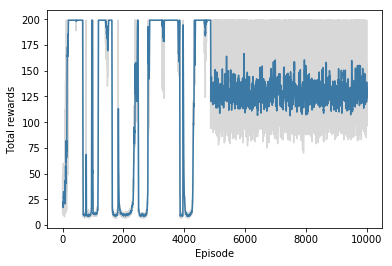

In [20]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Q losses')

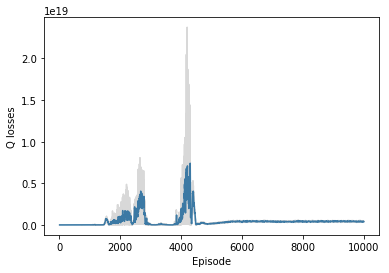

In [21]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

Text(0,0.5,'Q losses')

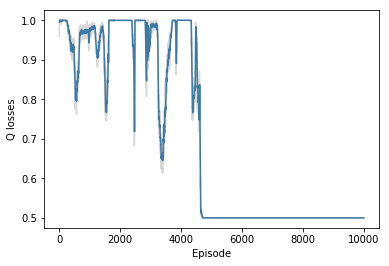

In [22]:
eps, arr = np.array(meanRs_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

Text(0,0.5,'Q losses')

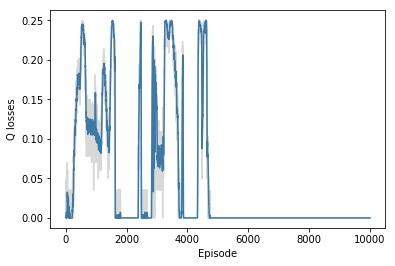

In [23]:
eps, arr = np.array(stdRs_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

## Testing

Let's checkout how our trained agent plays the game.

In [25]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/QGAN-cartpole.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [26]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.